### FINM33150 - Quant Trading Strategies
## Homework 4
## University of Chicago


### Author: Laurent Lanteigne
### ID: 12279717
### Date: April 29th, 2021

 # 1. Data
 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import random
import quandl
import datetime as dt
import functools
import seaborn as sns
import plotnine as p9
import os
from tqdm import tqdm
import copy
import time
from scipy.stats import norm
import statsmodels.api as sm


quandl_key = os.environ.get('QUANDL_API_KEY')

In [2]:
%matplotlib inline
pd.set_option("precision", 4)

In [3]:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [4]:
df_eth_usd = []
df_eth_btc = []
df_btc_usd = []
df_master = list((df_eth_usd, df_eth_btc, df_btc_usd))
for subdir, dirs, files in os.walk(os.getcwd()):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.split('\\')[-1].startswith("trades_narrow_ETH-USD"):
            if filepath.split('\\')[-1].endswith('2018.delim'):
                df_eth_usd.append(pd.read_csv(filepath, sep='|'))
            else:
                df_eth_usd.append(pd.read_csv(filepath, sep='\t'))
        elif filepath.split('\\')[-1].startswith("trades_narrow_ETH-BTC"):
            if filepath.split('\\')[-1].endswith('2018.delim'):
                df_eth_btc.append(pd.read_csv(filepath, sep='|'))
            else:
                df_eth_btc.append(pd.read_csv(filepath, sep='\t'))
        elif filepath.split('\\')[-1].startswith("trades_narrow_BTC-USD"):
            if filepath.split('\\')[-1].endswith('2018.delim'):
                df_btc_usd.append(pd.read_csv(filepath, sep='|'))
            else:
                df_btc_usd.append(pd.read_csv(filepath, sep='\t'))

In [5]:
df_eth_usd[0].tail()

,PriceMillionths,Side,SizeBillionths,received_utc_nanoseconds,timestamp_utc_nanoseconds
386675,415980000,-1,200000000,1523408800061706000,1523426800032000000
386676,415980000,-1,2392986770,1523408800062902000,1523426800032000000
386677,415980000,-1,10973230,1523408800064725000,1523426800032000000
386678,415840000,1,523200000,1523408803965848000,1523426803946000000
386679,415830000,-1,128000000,1523408803967797000,1523426803946000000


In [6]:
df_eth_usd[1].tail()

,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
306793,1618303122586738000,2165000000,47486920,-1
306794,1618303122793465000,2165000000,392226750,-1
306795,1618303122923682000,2164560000,10803650,1
306796,1618303123836600000,2164450000,70546230,1
306797,1618303123977590000,2164440000,55184590,-1


In [7]:
df_eth_usd[1]['Side'].unique()

array([  1,  -1,  -3,  -2,   2,  -5,   4,   6,   3,   5,  -4,  -6, -10,
        -8,  -9, -11,  -7,   7,   9,   8,  10, -13,  19,  11,  12,  40,
       -21, -15, -16,  17, -12,  14,  31, -14, -22,  21,  13,  15,  32,
        20,  56,  41,  22,   0, -28, -19, -17, -33, -29, -20, -23],
      dtype=int64)

Let's clean the Sides such that all we have is -1 or +1, let's also add a column for time since last trade. 

In [8]:
for i in range(len(df_master)):
    for j in range(len(df_master[i])):
        df_master[i][j] = df_master[i][j][df_master[i][j]['Side']!=0]
        # Changes all positives and negatives to +1/-1
        df_master[i][j]['Side'] = np.where(df_master[i][j]['Side']>0,1,-1)
        df_master[i][j]['time_btw_trades'] = df_master[i][j]['timestamp_utc_nanoseconds'].diff()
        df_master[i][j]['time_from_start'] = df_master[i][j]['time_btw_trades'].cumsum()

# 2. Analysis of a single trading pair BTC-USD 2021

## 2.1 Finding parameters of VWAP based on the data

In [9]:
df = copy.deepcopy(df_master[2][1])
transaction_cost = 0.005
total_elpased_time  = df['time_from_start'].iloc[-1]
print("Total Elapsed Time from start is = {}ns".format(total_elpased_time))

Total Elapsed Time from start is = 874100031337000.0ns


Considering we want our transactions to finish within 1-15minutes, let's find the parameters we need in order to finish ~5min.5min is 300s so it is 3e11 ns. 

In [10]:
num_of_5_min = total_elpased_time/3e11
num_of_5_min

2913.6667711233335

In [11]:
grouped_df_buy = df[df['Side']==1].groupby(pd.cut(df['time_from_start'][df['Side']==1], bins=int(num_of_5_min))).sum()
grouped_df_buy

,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,time_btw_trades,time_from_start
time_from_start,,,,,,
"(-873143598860.0, 301023817494.336]",9.5954e+20,3.5051e+13,1.7415e+10,593,2.2040e+11,9.7755e+13
"(301023817494.336, 601092157988.672]",9.7248e+20,3.5534e+13,1.9189e+10,601,2.2536e+11,2.6968e+14
"(601092157988.672, 901160498483.007]",8.8996e+20,3.2508e+13,1.1631e+10,550,2.2774e+11,4.1672e+14
"(901160498483.007, 1201228838977.343]",8.3980e+20,3.0635e+13,1.4351e+10,519,2.2617e+11,5.4678e+14
"(1201228838977.343, 1501297179471.679]",7.6051e+20,2.7750e+13,8.9089e+09,470,2.1291e+11,6.3363e+14
...,...,...,...,...,...,...
"(872599689634528.4, 872899757975022.8]",1.0572e+21,3.6849e+13,1.0636e+10,653,2.2325e+11,5.6991e+17
"(872899757975022.8, 873199826315517.0]",1.1689e+21,4.0795e+13,1.2341e+10,722,2.2289e+11,6.3034e+17
"(873199826315517.0, 873499894656011.4]",1.1414e+21,3.9863e+13,1.8097e+10,705,2.2414e+11,6.1571e+17


In [12]:
grouped_df_sell = df[df['Side']==-1].groupby(pd.cut(df['time_from_start'][df['Side']==-1], bins=int(num_of_5_min))).sum()
grouped_df_sell

,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,time_btw_trades,time_from_start
time_from_start,,,,,,
"(-874099425754.0, 300068460608.994]",3.7055e+20,1.3530e+13,6.7144e+09,-229,7.8290e+10,2.1617e+13
"(300068460608.994, 600136921217.988]",3.9967e+20,1.4603e+13,1.1203e+10,-247,7.6876e+10,1.0760e+14
"(600136921217.988, 900205381826.982]",3.4304e+20,1.2531e+13,1.5284e+10,-212,7.1558e+10,1.5991e+14
"(900205381826.982, 1200273842435.976]",3.8835e+20,1.4164e+13,8.4640e+09,-240,7.4829e+10,2.5131e+14
"(1200273842435.976, 1500342303044.971]",3.5113e+20,1.2813e+13,7.4472e+09,-217,8.7116e+10,2.9406e+14
...,...,...,...,...,...,...
"(872599083450955.0, 872899151911564.0]",3.9665e+20,1.3825e+13,6.3647e+09,-245,7.7082e+10,2.1382e+17
"(872899151911564.0, 873199220372173.0]",5.7474e+20,2.0062e+13,2.6692e+10,-355,7.6947e+10,3.0994e+17
"(873199220372173.0, 873499288832782.0]",6.2655e+20,2.1880e+13,3.0322e+10,-387,7.6513e+10,3.3799e+17


Note how the column time_from_start is now the sum of the time_from_start within each 5 minutes. Let's fix that for the next groupby.

In [13]:
for i in range(len(grouped_df_sell.index)):
    grouped_df_sell['time_from_start'].iloc[i] = grouped_df_sell.index[i].right
    grouped_df_buy['time_from_start'].iloc[i] = grouped_df_buy.index[i].right
grouped_df_sell

,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,time_btw_trades,time_from_start
time_from_start,,,,,,
"(-874099425754.0, 300068460608.994]",3.7055e+20,1.3530e+13,6.7144e+09,-229,7.8290e+10,3.0007e+11
"(300068460608.994, 600136921217.988]",3.9967e+20,1.4603e+13,1.1203e+10,-247,7.6876e+10,6.0014e+11
"(600136921217.988, 900205381826.982]",3.4304e+20,1.2531e+13,1.5284e+10,-212,7.1558e+10,9.0021e+11
"(900205381826.982, 1200273842435.976]",3.8835e+20,1.4164e+13,8.4640e+09,-240,7.4829e+10,1.2003e+12
"(1200273842435.976, 1500342303044.971]",3.5113e+20,1.2813e+13,7.4472e+09,-217,8.7116e+10,1.5003e+12
...,...,...,...,...,...,...
"(872599083450955.0, 872899151911564.0]",3.9665e+20,1.3825e+13,6.3647e+09,-245,7.7082e+10,8.7290e+14
"(872899151911564.0, 873199220372173.0]",5.7474e+20,2.0062e+13,2.6692e+10,-355,7.6947e+10,8.7320e+14
"(873199220372173.0, 873499288832782.0]",6.2655e+20,2.1880e+13,3.0322e+10,-387,7.6513e+10,8.7350e+14


In [14]:
grouped_df_buy

,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,time_btw_trades,time_from_start
time_from_start,,,,,,
"(-873143598860.0, 301023817494.336]",9.5954e+20,3.5051e+13,1.7415e+10,593,2.2040e+11,3.0102e+11
"(301023817494.336, 601092157988.672]",9.7248e+20,3.5534e+13,1.9189e+10,601,2.2536e+11,6.0109e+11
"(601092157988.672, 901160498483.007]",8.8996e+20,3.2508e+13,1.1631e+10,550,2.2774e+11,9.0116e+11
"(901160498483.007, 1201228838977.343]",8.3980e+20,3.0635e+13,1.4351e+10,519,2.2617e+11,1.2012e+12
"(1201228838977.343, 1501297179471.679]",7.6051e+20,2.7750e+13,8.9089e+09,470,2.1291e+11,1.5013e+12
...,...,...,...,...,...,...
"(872599689634528.4, 872899757975022.8]",1.0572e+21,3.6849e+13,1.0636e+10,653,2.2325e+11,8.7290e+14
"(872899757975022.8, 873199826315517.0]",1.1689e+21,4.0795e+13,1.2341e+10,722,2.2289e+11,8.7320e+14
"(873199826315517.0, 873499894656011.4]",1.1414e+21,3.9863e+13,1.8097e+10,705,2.2414e+11,8.7350e+14


These two dataframes gives us some information on the average values for the columns for each 5 minutes that goes by. We would expect the values to be somewhat close and they seem to be. Considering that we need to find our "participate rate" $p$ and "chunk rate" $c$. A natural value for $p \cdot c$ would be the mean value of the size of trade within 5 minutes. Let's first start by trying to liquidate our position given 2 days of trading, this will be the equivalent $2\cdot 24\cdot12$ trenches of 5 minutes which is 576 blocks of 5 minutes. Let's have a participation rate of 1%. Since some trade quantities are much larger than $c$, we achieve less than $p$ as a proportion of total volume so size our total position $Q$ has 1% of 500 blocks of 5 minutes. We'll groupby our previous dataframe in 6 which will be a little less than 500, closer to 485 blocks of 5 minutes. 

After revision of Tuesday's class, I realized I misunderstood what was the intention with the 1-15 minutes, which I have properly corrected for the Sell-Side. I feel like it is relevant to keep this analysis in order to compare how they differ giver a large block of time vs a smaller one. 

In [15]:
p = 0.01
c_buy = grouped_df_buy['SizeBillionths'].mean()
c_sell = grouped_df_sell['SizeBillionths'].mean()

In [16]:
grouped_df_buy_2 = grouped_df_buy.groupby(pd.cut(grouped_df_buy['time_from_start'], bins=6)).sum()
grouped_df_buy_2

,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,time_btw_trades,time_from_start
time_from_start,,,,,,
"(-572775190025.169, 145934191737411.94]",3.3482e+23,1.2395e+16,7.3495e+12,206913,1.0056e+14,3.5511e+16
"(145934191737411.94, 291567359657329.5]",5.8712e+23,2.2545e+16,1.4932e+13,362793,1.0041e+14,1.0609e+17
"(291567359657329.5, 437200527577247.06]",6.9319e+23,2.7010e+16,1.5150e+13,428299,1.0309e+14,1.7668e+17
"(437200527577247.06, 582833695497164.8]",7.2055e+23,2.7498e+16,1.4883e+13,445166,1.1158e+14,2.4784e+17
"(582833695497164.8, 728466863417082.4]",1.1021e+24,3.8493e+16,2.3213e+13,680845,1.1691e+14,3.1799e+17
"(728466863417082.4, 874100031336999.9]",7.6832e+23,2.6410e+16,1.6715e+13,474592,1.1052e+14,3.8945e+17


In [17]:
grouped_df_sell_2 = grouped_df_sell.groupby(pd.cut(grouped_df_sell['time_from_start'], bins=6)).sum()
grouped_df_sell_2

,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,time_btw_trades,time_from_start
time_from_start,,,,,,
"(-573730896684.397, 145933294676174.16]",1.8020e+23,6.6731e+15,6.9645e+12,-111361,4.5276e+13,3.5510e+16
"(145933294676174.16, 291566520891739.3]",3.0305e+23,1.1638e+16,1.2400e+13,-187258,4.5120e+13,1.0609e+17
"(291566520891739.3, 437199747107304.5]",3.3923e+23,1.3221e+16,1.3966e+13,-209597,4.2533e+13,1.7711e+17
"(437199747107304.5, 582832973322869.6]",2.9597e+23,1.1285e+16,1.2204e+13,-182856,3.4165e+13,2.4741e+17
"(582832973322869.6, 728466199538434.8]",4.5208e+23,1.5767e+16,2.1609e+13,-279277,2.8626e+13,3.1799e+17
"(728466199538434.8, 874099425754000.0]",3.3834e+23,1.1623e+16,1.4795e+13,-208991,3.5317e+13,3.8945e+17


We take one hundreth of the average of size as our Q, since our participation rate is 1%.

In [18]:
Q_buy = int(int(grouped_df_buy_2['SizeBillionths'].mean()/(1e7))*1e5)
Q_sell = int(int(grouped_df_sell_2['SizeBillionths'].mean()/(1e7))*1e5)

In [19]:
print("Parameters for the VWAP Buy-Side: Q={:.2f} shares, p={:.2f}%, c={:.2f} shares \
    \nParameters for the VWAP Sell-Side: Q={:.2f} shares, p={:.2f}%, c={:.2f} shares".format(Q_buy/1e9, p*100, c_buy/1e9, Q_sell/1e9, p*100, c_sell/1e9))

Parameters for the VWAP Buy-Side: Q=153.74 shares, p=1.00%, c=31.67 shares     
Parameters for the VWAP Sell-Side: Q=136.56 shares, p=1.00%, c=28.13 shares


The dividing by 10 000 then multiplying by 10 000 is to make it a slightly easier number of shares to liquidate. These makes sense based on the set-up we are looking for. We want to be trading 1% of the market so everytime there are ~30 shares traded we want to participate in around 0.3 of those. We see about ~30 shares being traded every 5 minutes so if we participate every 5 minutes at 0.3 shares a time it will take around 500 blocks of 5 minutes to reach 150 shares traded which is around our initial Q. 

In [20]:
df_buy = df[df['Side']==1]
df_sell = df[df['Side']==-1]
print(df_buy.shape)
print(df_sell.shape)

(2598608, 6)
(1179341, 6)


Let's use a random initial time in the first quarter of our data, this should give us enough time to liquidate our position while not cherry picking our starting point.

In [21]:
# Seed to be able to reproduce results
np.random.seed(0)
start_time_buy_idx = np.random.randint(0.25*df_buy.shape[0])
start_time_sell_idx = np.random.randint(0.25*df_buy.shape[0])

In [22]:
df_buy = df_buy[df_buy.index >= start_time_buy_idx]
df_buy = df_buy.reset_index()
df_buy.drop(['index'], inplace = True, axis = 1)
df_sell = df_sell[df_sell.index >= start_time_sell_idx]
df_sell = df_sell.reset_index()
df_sell.drop(['index'], inplace = True, axis = 1)
df_buy.head()

,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,time_btw_trades,time_from_start
0,1618249295597041000,60396320000,851980,1,0.0000e+00,1.4116e+14
1,1618249295597041000,60396520000,2000000,1,0.0000e+00,1.4116e+14
2,1618249295911878000,60398390000,173460,1,3.1484e+08,1.4116e+14
3,1618249295928253000,60398390000,673990,1,1.6375e+07,1.4116e+14
4,1618249295928253000,60398990000,2143920,1,0.0000e+00,1.4116e+14


We cleaned up the index but the first value of time_btw_trades and the time_from_start column is incorrect now so let's reset it. 

In [23]:
df_buy['time_btw_trades'][0] = 0 
df_sell['time_btw_trades'][0] = 0 
df_buy['time_from_start'] = df_buy['time_btw_trades'].cumsum()
df_sell['time_from_start'] = df_sell['time_btw_trades'].cumsum()
df_buy.head()

,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,time_btw_trades,time_from_start
0,1618249295597041000,60396320000,851980,1,0.0000e+00,0.0000e+00
1,1618249295597041000,60396520000,2000000,1,0.0000e+00,0.0000e+00
2,1618249295911878000,60398390000,173460,1,3.1484e+08,3.1484e+08
3,1618249295928253000,60398390000,673990,1,1.6375e+07,3.3121e+08
4,1618249295928253000,60398990000,2143920,1,0.0000e+00,3.3121e+08


Since our activity in the market depends on the number of size traded from last time we participated in the market. Let's add another column to keep track of the participation thus far.

In [24]:
df_buy['size_cumulative'] = df_buy['SizeBillionths'].cumsum()
df_sell['size_cumulative'] = df_sell['SizeBillionths'].cumsum()
df_buy['trade_size'] = 0 
df_sell['trade_size'] = 0 
df_buy['trade_price_exec'] = 0 
df_sell['trade_price_exec'] = 0 
df_buy['trade_best_price'] = 0 
df_sell['trade_best_price'] = 0 
df_buy.head()

,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,time_btw_trades,time_from_start,size_cumulative,trade_size,trade_price_exec,trade_best_price
0,1618249295597041000,60396320000,851980,1,0.0000e+00,0.0000e+00,851980,0,0,0
1,1618249295597041000,60396520000,2000000,1,0.0000e+00,0.0000e+00,2851980,0,0,0
2,1618249295911878000,60398390000,173460,1,3.1484e+08,3.1484e+08,3025440,0,0,0
3,1618249295928253000,60398390000,673990,1,1.6375e+07,3.3121e+08,3699430,0,0,0
4,1618249295928253000,60398990000,2143920,1,0.0000e+00,3.3121e+08,5843350,0,0,0


We'll focus on one dataframe for now, we will running the VWAP simulation for liquidating by having a positive quantity. We will assume that our time of execution in the market is 0.1s, this mean that whenever we want to open a trade, we will take the worst price within the next 0.1s and afterwards take the next prices available until we meet our participation requirements.

## 2.2 VWAP Buy-Side Simulation

In [25]:
df_buy['trade_size'] = 0 
df_buy.head()

,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,time_btw_trades,time_from_start,size_cumulative,trade_size,trade_price_exec,trade_best_price
0,1618249295597041000,60396320000,851980,1,0.0000e+00,0.0000e+00,851980,0,0,0
1,1618249295597041000,60396520000,2000000,1,0.0000e+00,0.0000e+00,2851980,0,0,0
2,1618249295911878000,60398390000,173460,1,3.1484e+08,3.1484e+08,3025440,0,0,0
3,1618249295928253000,60398390000,673990,1,1.6375e+07,3.3121e+08,3699430,0,0,0
4,1618249295928253000,60398990000,2143920,1,0.0000e+00,3.3121e+08,5843350,0,0,0


In [26]:
def VWAP_simulation(Q, c, p, df_):
    
    df = copy.deepcopy(df_)
    log_trades = {}
    trades_in_flurry = {}
    first_trade_participation = {}

    num_of_participation = 0 
    size_to_liquidate = Q
    size_threshold = c
    participation_size = p * c
    # This flag will be True after we participated in the market and are still participating 
    active_mkt_flag = False

    # This size will be reset everytime we finish participating in the market 
    curr_size = participation_size

    i = 0 

    while i < len(df):
        # If we have liquidated our position we exit
        if size_to_liquidate == 0:
            break
        # Check whether or not we should participate in a trade if the cumulative is too small
        if df['size_cumulative'].loc[i] < (num_of_participation + 1) * size_threshold:
            i += 1 
            continue

        # We engage in the market 
        else:
            if active_mkt_flag:
                price = df['PriceMillionths'].loc[i]
                size = df['SizeBillionths'].loc[i]
                # Check whether we buy full order or only partially fill 
                if size > curr_size:
                    log_trades[df['timestamp_utc_nanoseconds'].loc[i]] = (curr_size, price)
                    df['trade_size'][i] = curr_size
                    size_to_liquidate -= curr_size
                    num_of_participation += 1
                    # Update leftover size to trade based on smallest of the participate size and what's left to liquidate
                    curr_size = np.min([participation_size, size_to_liquidate])
                    active_mkt_flag = False 
                # If we partially fill the order, we stay active in the market 
                else:
                    log_trades[df['timestamp_utc_nanoseconds'].loc[i]] = (size, price)
                    df['trade_size'][i] = size
                    
                    size_to_liquidate -= size
                    # Update leftover size to trade based on smallest of what's left to participate and what's left to liquidate 
                    curr_size = np.min([curr_size-size, size_to_liquidate])
                    active_mkt_flag = True 
                    
                df['trade_price_exec'][i] = price
                i +=1 
            # Take the worst trade in the next 0.1s
            else:            
                # Index of last trade in the next 0.1ns
                idx_last_trade = np.where(df['time_from_start'].loc[i:] < df['time_from_start'].loc[i] + 1e8)[-1][-1] + i

                # check for the worst price based on buy side or sell side 
                if df['Side'].loc[i] > 0:
                    # Considering people are buying the worst trade will be lowest price 
                    idx_transaction = df['PriceMillionths'].loc[i:idx_last_trade].argmin() + i 
                    price = df['PriceMillionths'].loc[idx_transaction]
                    # We take the size of availability to be the sum of the size of all the trades within 0.1ns but we take the worst price of the bunch
                    size = df['SizeBillionths'].loc[i:idx_transaction].sum()
                    
                    # This is for analysis later, we want to see how notional changes based on if we had the possibility of taking best price
                    idx_optimal = df['PriceMillionths'].loc[i:idx_last_trade].argmax() + i 
                    df['trade_best_price'][i] = df['PriceMillionths'].loc[idx_optimal]

                else:
                    # Considering people are selling the worst trade will be highest price 
                    idx_transaction = df['PriceMillionths'].loc[i:idx_last_trade].argmax() + i 
                    price = df['PriceMillionths'].loc[idx_transaction]
                    # We take the size of availability to be the sum of the size of all the trades within 0.1ns but we take the worst price of the bunch
                    size = df['SizeBillionths'].loc[idx_transaction]
                    
                    # This is for analysis later, we want to see how notional changes based on if we had the possibility of taking best price
                    idx_optimal = df['PriceMillionths'].loc[i:idx_last_trade].argmin() + i 
                    df['trade_best_price'][i] = df['PriceMillionths'].loc[idx_optimal]

                # Check whether we buy full order or only partially fill 
                if size > curr_size:
                    log_trades[df['timestamp_utc_nanoseconds'].loc[i]] = (curr_size, price)
                    df['trade_size'][i] = curr_size
                    size_to_liquidate -= curr_size
                    num_of_participation += 1
                    # Update leftover size to trade based on smallest of the participate size and what's left to liquidate
                    curr_size = np.min([participation_size, size_to_liquidate])

                # If we partially fill the order, we stay active in the market 
                else:
                    log_trades[df['timestamp_utc_nanoseconds'].loc[i]] = (size, price)
                    df['trade_size'][i] = size
                    size_to_liquidate -= size
                    # Update leftover size to trade based on smallest of what's left to participate and what's left to liquidate 
                    curr_size = np.min([curr_size-size, size_to_liquidate])
                    active_mkt_flag = True 

                # If we did a transaction not at best price, log-it 
                if idx_transaction != i:
                    trades_in_flurry[df['timestamp_utc_nanoseconds'].loc[i]] = (np.min([curr_size,size]), price)

                # Log first trade in each participation for analysis 
                first_trade_participation[df['timestamp_utc_nanoseconds'].loc[i]] = (np.min([curr_size,size]), price)
                
                df['trade_price_exec'][i] = price
                # Reset the value of i to be the next timestamp after the 0.1ns that passed from us entering the market 
                i = idx_transaction + 1
                
    cumul_size_traded_mkt = df['size_cumulative'].loc[i-1]
    participation_rate = Q/cumul_size_traded_mkt
    
    # We want to add trade prices where we don't have a best price traded possibility to have a view of the entire trading scenarios / (Added analysis)
    df['trade_best_price'] += np.where(df['trade_best_price'] == 0, df['trade_price_exec'],0)
    #Let's remove all the indexes after we are done transacting in the market.
    df = df[:i]
    return df, num_of_participation, size_to_liquidate, participation_rate, log_trades, trades_in_flurry, first_trade_participation 


df_buy_side, num_of_participation_buy, size_to_liquidate_buy, participation_rate_buy, log_trades_buy, trades_in_flurry_buy, first_trade_participation_buy = VWAP_simulation(Q_buy, c_buy, p, df_buy)

Let's check if we properly engaged in the market by checking how much residual size we have and how often we participated.

In [27]:
print("Residual size of account: {:.2f} shares \nNumber of Participations: {} \
      \nParticipation Rate: {:.3f}%".format(size_to_liquidate_buy, num_of_participation_buy, participation_rate_buy*100))

Residual size of account: 0.00 shares 
Number of Participations: 486       
Participation Rate: 0.999%


Considering we made so adjustment in the grouping of the dataframe earlier and estimated number of times we participate in the market to be 485, we are fairly close. Now, let's look at average time spent in the market.

In [28]:
time_of_first_trades_buy = []
for timestamp, trades in first_trade_participation_buy.items():
    time_of_first_trades_buy.append(timestamp)
time_of_first_trades_buy = np.array(sorted(time_of_first_trades_buy))
average_time_btw_trades_buy = 1e-9 * (time_of_first_trades_buy[1:] - time_of_first_trades_buy[:-1]).mean()
print("Average Time spent between trades is {:.2f}s".format(average_time_btw_trades_buy))

Average Time spent between trades is 308.35s


Participation rate of 0.998% with a goal of 1% and average time spent is nearly the 300s we were looking for, it seems like the trading was properly executed. Let's see if we executed some trades where we had to take a worst price due to time execution of 0.1ns, going on forward we will labeled these as sub-optimal trades.  

In [29]:
for timestamp, trades in trades_in_flurry_buy.items():
    print(timestamp, trades)

1618273151702181000 (316660835.2458634, 59891690000)
1618280400024463000 (316660835.2458634, 59845360000)
1618292224553691000 (316660835.2458634, 60268480000)
1618296025635251000 (316660835.2458634, 60482760000)
1618299597841618000 (316660835.2458634, 60847170000)
1618299624918506000 (316660835.2458634, 60871460000)
1618304357957559000 (119570180.0, 60413470000)
1618315826003089000 (316660835.2458634, 60873310000)
1618316770743280000 (316660835.2458634, 60866570000)
1618318604934853000 (316660835.2458634, 61107610000)
1618319778952302000 (316660835.2458634, 61999330000)
1618319874398060000 (316660835.2458634, 62177790000)
1618319966022308000 (316660835.2458634, 62259580000)
1618320469592285000 (316660835.2458634, 62432080000)
1618321171877295000 (3739980.0, 62689990000)
1618325382536674000 (316660835.2458634, 62999900000)
1618333350768836000 (316660835.2458634, 62824520000)
1618334199693487000 (316660835.2458634, 63212430000)
1618335286862854000 (30708180.0, 62980490000)
16183368465270

## 2.3 VWAP Sell-Side Simulation

We observe some trades that were executed in sub-optimal scenario. Let's now look at the Sell-Side and change some of the parameters, we are going to using VWAP but instead we'll aim at a higher participation rate of 20% and a total trading period of 15minutes. Let's start by figuring out the parameters $c$ and $Q$ to be within grasps of what we are aiming. Since we want to liquidate our position in about 15minutes and we are participating in 20% of the trading activity, we want a size $Q$ that would reflect about 3minutes of trading. As for $c$, we will assume that we will interact in the market only about 50 times, instead of previously 500 times. Therefore $c \approx \frac{Q}{50\cdot p }$.

In [30]:
num_of_3_min = total_elpased_time/1.8e11
grouped_df_sell = df[df['Side']==-1].groupby(pd.cut(df['time_from_start'][df['Side']==-1], bins=int(num_of_3_min))).sum()
grouped_df_sell

,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,time_btw_trades,time_from_start
time_from_start,,,,,,
"(-874099425754.0, 180004000361.203]",3.0744e+20,1.1224e+13,6.2110e+09,-190,5.9891e+10,1.2628e+13
"(180004000361.203, 360008000722.405]",1.5372e+20,5.6205e+12,4.6291e+09,-95,3.4133e+10,2.7567e+13
"(360008000722.405, 540012001083.608]",2.6052e+20,9.5152e+12,5.4708e+09,-161,4.8121e+10,7.2120e+13
"(540012001083.608, 720016001444.81]",1.7799e+20,6.5047e+12,3.3497e+09,-110,4.4684e+10,6.9389e+13
"(720016001444.81, 900020001806.013]",2.1359e+20,7.7991e+12,1.3541e+10,-132,3.9895e+10,1.0741e+14
...,...,...,...,...,...,...
"(873199405752194.0, 873379409752555.2]",3.6103e+20,1.2612e+13,2.5091e+10,-223,4.3195e+10,1.9475e+17
"(873379409752555.2, 873559413752916.4]",4.1284e+20,1.4401e+13,8.2007e+09,-255,4.7819e+10,2.2274e+17
"(873559413752916.4, 873739417753277.6]",3.8208e+20,1.3334e+13,5.1121e+09,-236,5.2412e+10,2.0618e+17


In [31]:
p = 0.2
Q_sell = int(int(grouped_df_sell['SizeBillionths'].mean()/(1e7))*1e7)
c_sell = Q_sell/(50*p)
print("Parameters for the VWAP Sell-Side: Q={:.2f} shares, p={:.2f}%, c={:.2f} shares".format(Q_sell/1e9, p*100, c_sell/1e9))

Parameters for the VWAP Sell-Side: Q=16.87 shares, p=20.00%, c=1.69 shares


We've already cleaned up sell side dataframe and have a random start point so we can just use that and proceed like the Buy-Side.

In [32]:
df_sell

,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,time_btw_trades,time_from_start,size_cumulative,trade_size,trade_price_exec,trade_best_price
0,1618293263416516000,60374080000,668140,-1,0.0000e+00,0.0000e+00,668140,0,0,0
1,1618293263734756000,60374080000,143440,-1,3.1824e+08,3.1824e+08,811580,0,0,0
2,1618293272950749000,60382180000,792420,-1,2.9918e+08,6.1742e+08,1604000,0,0,0
3,1618293273247362000,60388830000,3044810,-1,2.9661e+08,9.1403e+08,4648810,0,0,0
4,1618293273580818000,60388990000,635490,-1,3.3346e+08,1.2475e+09,5284300,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1030313,1618982229387097000,56692960000,12100000,-1,0.0000e+00,1.7507e+14,72227585740300,0,0,0
1030314,1618982229387097000,56692970000,29391890,-1,0.0000e+00,1.7507e+14,72227615132190,0,0,0
1030315,1618982229661754000,56692970000,380140,-1,2.7466e+08,1.7507e+14,72227615512330,0,0,0
1030316,1618982230168098000,56692970000,161100,-1,1.0019e+08,1.7507e+14,72227615673430,0,0,0


In [33]:
df_sell_side, num_of_participation_sell, size_to_liquidate_sell, participation_rate_sell, log_trades_sell, trades_in_flurry_sell, first_trade_participation_sell = VWAP_simulation(Q_sell, c_sell, p, df_sell)

In [34]:
print("Residual size of account: {:.2f} shares \nNumber of Participations: {} \
      \nParticipation Rate: {:.3f}%".format(size_to_liquidate_sell, num_of_participation_sell, participation_rate_sell*100))

Residual size of account: 0.00 shares 
Number of Participations: 50       
Participation Rate: 19.802%


In [35]:
time_of_first_trades_sell = []
for timestamp, trades in first_trade_participation_sell.items():
    time_of_first_trades_sell.append(timestamp)
time_of_first_trades_sell = np.array(sorted(time_of_first_trades_sell))
average_time_btw_trades_sell = 1e-9 * (time_of_first_trades_sell[1:] - time_of_first_trades_sell[:-1]).mean()
print("Average Time spent between trades is {:.2f}s".format(average_time_btw_trades_sell))

Average Time spent between trades is 29.97s


Comparing the targeted participation rate versus realized one we expect it to be a slightly lower than target but, in the Buy,-Side case, we are actually much closer. This is due to two principal factors in my opinion, the first one being less active in the market. It is much easier to realize the targeted participation rate when there are more frequent but smaller trades in the market. The second reason is that given a bigger timeframe, it is more likely that the total number of shares traded in that period is closer to the mean than given a smaller timeframe. Let's look if we had to take sub optimal trades.

In [36]:
trades_time = []
prices = []
for timestamp, trades in trades_in_flurry_sell.items():
    print(timestamp, trades)
    
    if int(timestamp) >= 1618294703442976000:
        trades_time.append(timestamp)
        prices.append(trades[1])

1618293631657287000 (16936670.0, 60399940000)
1618293635881893000 (61750000.0, 60384550000)
1618293638833965000 (40000000.0, 60387350000)
1618294377244718000 (2908450.0, 60380670000)
1618294598237625000 (12434830.0, 60312330000)
1618294612278268000 (6200630.0, 60288670000)
1618294703442976000 (12790000.0, 60279310000)
1618294707949306000 (98275740.0, 60271820000)
1618294710950325000 (61750000.0, 60271480000)
1618294754523087000 (9430670.0, 60261070000)
1618294794736066000 (17572880.0, 60200540000)
1618294797075390000 (4155320.0, 60189130000)


In [37]:
trades_in_flurry_sell[1618293638833965000]

(40000000.0, 60387350000)

Let's look more closely of trades we did a flurry.

In [38]:
df_temp_buy = df[df['Side']==1][(df['timestamp_utc_nanoseconds'] >= 1618294710950325000) & (df['timestamp_utc_nanoseconds'] <= 1618294817075390000)]
df_temp_sell = df[df['Side']==-1][(df['timestamp_utc_nanoseconds'] >= 1618294693442976000) & (df['timestamp_utc_nanoseconds'] <= 1618294817075390000)]

x_sell = 1e-9*(df_temp_sell['timestamp_utc_nanoseconds'] - df_temp_sell['timestamp_utc_nanoseconds'].iloc[0]).values
x_buy = 1e-9*(df_temp_buy['timestamp_utc_nanoseconds'] - df_temp_sell['timestamp_utc_nanoseconds'].iloc[0]).values
y_sell = df_temp_sell['PriceMillionths']
y_buy = df_temp_buy['PriceMillionths']

df_trades = pd.DataFrame()
df_trades['Time'] = 1e-9*(trades_time - df_temp_sell['timestamp_utc_nanoseconds'].iloc[0])
df_trades['Price'] = prices
df_trades.set_index('Time', inplace = True)
df_trades

<ipython-input-38-0483764daac8>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<ipython-input-38-0483764daac8>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Price
Time,
9.5707,60279310000
14.0770,60271820000
17.0780,60271480000
60.6508,60261070000
100.8638,60200540000
103.2031,60189130000


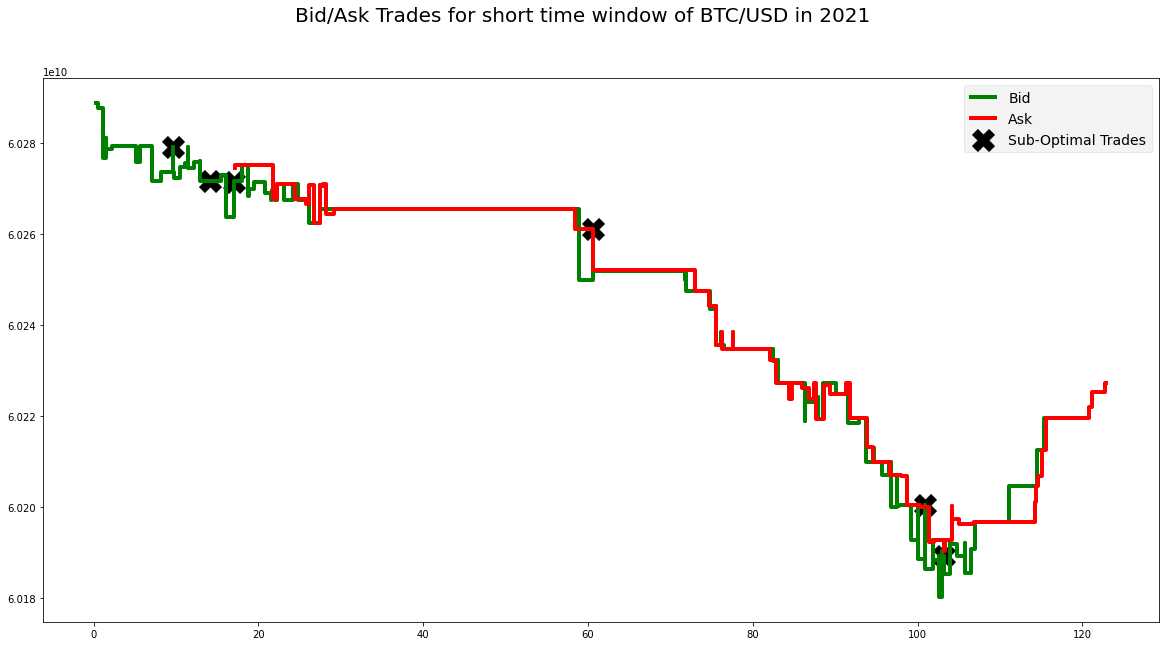

In [39]:
fig, axs = plt.subplots(1,1,figsize=(20,10))
plt.style.use('fivethirtyeight')
fig.suptitle('Bid/Ask Trades for short time window of BTC/USD in 2021', fontsize = 20)

axs.plot(x_sell, y_sell, drawstyle='steps', c='green', label = 'Bid')
axs.plot(x_buy, y_buy, drawstyle='steps', c='red', label = 'Ask')
axs.scatter(df_trades.index, df_trades.Price, color = 'k', s= 500, marker = 'X', label = 'Sub-Optimal Trades')
axs.legend()

Let's zoom and see when it is more clear that we crossing the bid/ask Spread

In [40]:
df_temp_buy = df[df['Side']==1][(df['timestamp_utc_nanoseconds'] >= 1618293638833965000-2e9) & (df['timestamp_utc_nanoseconds'] <= 1618293638833965000+2e9)]
df_temp_sell = df[df['Side']==-1][(df['timestamp_utc_nanoseconds'] >= 1618293638833965000-2e9) & (df['timestamp_utc_nanoseconds'] <= 1618293638833965000+2e9)]

x_sell = 1e-9*(df_temp_sell['timestamp_utc_nanoseconds'] - df_temp_sell['timestamp_utc_nanoseconds'].iloc[0]).values
x_buy = 1e-9*(df_temp_buy['timestamp_utc_nanoseconds'] - df_temp_sell['timestamp_utc_nanoseconds'].iloc[0]).values
y_sell = df_temp_sell['PriceMillionths']
y_buy = df_temp_buy['PriceMillionths']

time =  1e-9*(1618293638833965000 - df_temp_sell['timestamp_utc_nanoseconds'].iloc[0])
price = trades_in_flurry_sell[1618293638833965000][1]


<ipython-input-40-d906021187fb>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<ipython-input-40-d906021187fb>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


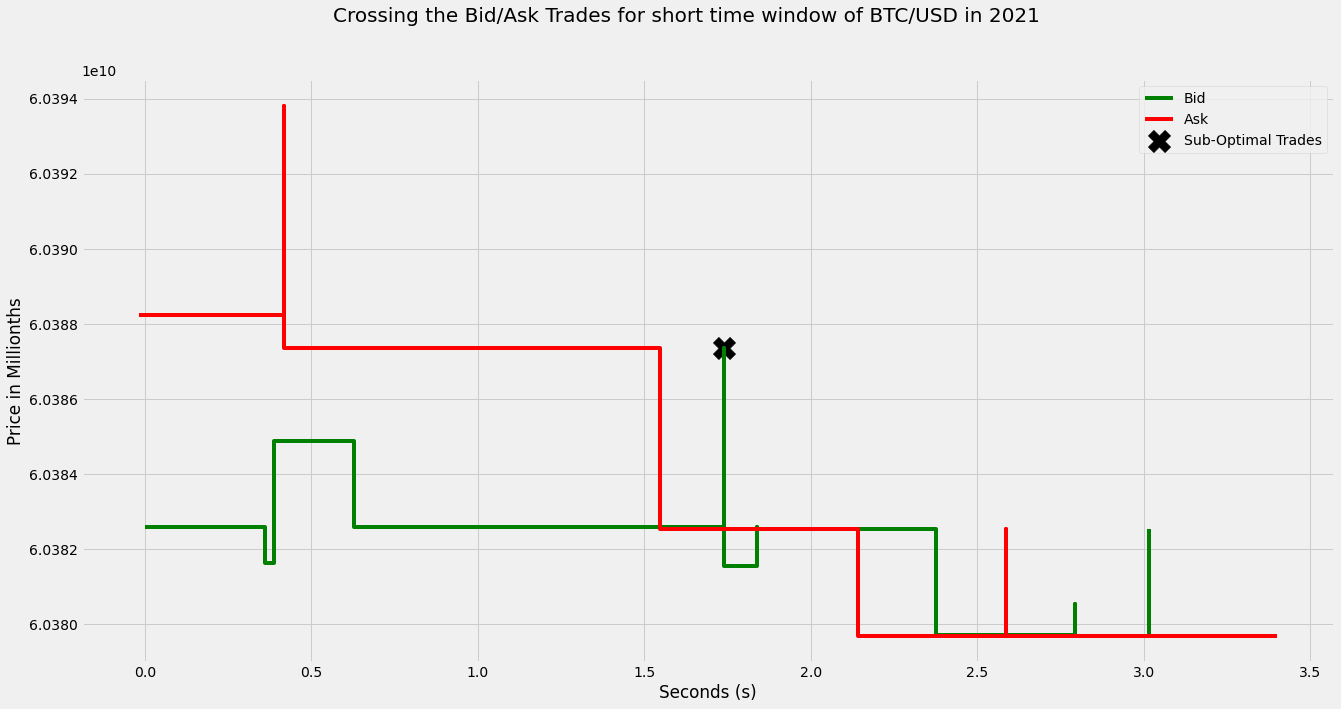

In [41]:
fig, axs = plt.subplots(1,1,figsize=(20,10))
plt.style.use('fivethirtyeight')
fig.suptitle('Crossing the Bid/Ask Trades for short time window of BTC/USD in 2021', fontsize = 20)

axs.plot(x_sell, y_sell, drawstyle='steps',c='green', label = 'Bid')
axs.plot(x_buy, y_buy, drawstyle='steps', c='red', label = 'Ask')
axs.scatter(time, price, color = 'k', s= 500, marker = 'X', label = 'Sub-Optimal Trades')
axs.set_xlabel('Seconds (s)')
axs.set_ylabel('Price in Millionths')
axs.legend()

## 2.4 Comparing Buy-Side vs Sell-Side VWAP Simulations

In [42]:
print("Ratio of sub-optimal trades Buy-Side = {:.2f}% \nRatio of sub-optimal trades \
Sell-Side = {:.2f}%".format(100*len(trades_in_flurry_buy)/df_buy_side[df_buy_side['trade_size']!=0].count()[0],100*len(trades_in_flurry_sell)/df_sell_side[df_sell_side['trade_size']!=0].count()[0]))

Ratio of sub-optimal trades Buy-Side = 1.03% 
Ratio of sub-optimal trades Sell-Side = 4.56%


In [43]:
print("Participation Size when entering market for Buy-Side = {:.2f} shares \
     \nParticipation Size when entering market for Sell-Side = {:.2f} shares".format(1e-9*c_buy*0.01, 1e-9*c_sell*0.2))

Participation Size when entering market for Buy-Side = 0.32 shares      
Participation Size when entering market for Sell-Side = 0.34 shares


Interesting enough, even though we coded trades that are considered sub-optimal to only have a chance of occuring when we start engaging in the market, the ratio of transactions done sub-optimally in the Sell-Side simulation is higher than the Buy-Side simulation. We only have a sub-optimal trade when we initially engage in the market and there are more than 1 trades occuring in the next 0.1ns. If the frequency of trades on both sides would be similar, then we should expect these two numbers to be very close if the trading size is similar. But if we look at the shape of the dataframes, we observe that we have more orders occuring on the Buy-Side than Sell-Side, so theoretically, we should expect higher frequency of sub-optimal trades on the Buy-Side considering we have chosen parameters that have a similar participation size when we transact in the market. This is probably due to the small population sample on the Sell-Side.

I had to switch from billionths for size and millionths for price since the multiplication of the two columns would create numbers big enough to have memory leak and I was getting negative values from multiplication of two positive floats.

In [44]:
dfs = [df_buy_side, df_sell_side]
for i in range(len(dfs)):
    dfs[i]['trade_notional_first_$'] = ((1e-15)*dfs[i]['trade_size']).mul(dfs[i]['PriceMillionths']) * (1+transaction_cost)
    dfs[i]['trade_notional_exec_$'] = ((1e-15)*dfs[i]['trade_size']).mul(dfs[i]['trade_price_exec']) * (1+transaction_cost)
    dfs[i]['trade_notional_best_$'] = ((1e-15)*dfs[i]['trade_size']).mul(dfs[i]['trade_best_price']) * (1+transaction_cost)

    dfs[i]['cumul_notional_first_$'] = dfs[i]['trade_notional_first_$'].cumsum()
    dfs[i]['cumul_notional_exec_$'] = dfs[i]['trade_notional_exec_$'].cumsum()
    dfs[i]['cumul_notional_best_$'] = dfs[i]['trade_notional_best_$'].cumsum()

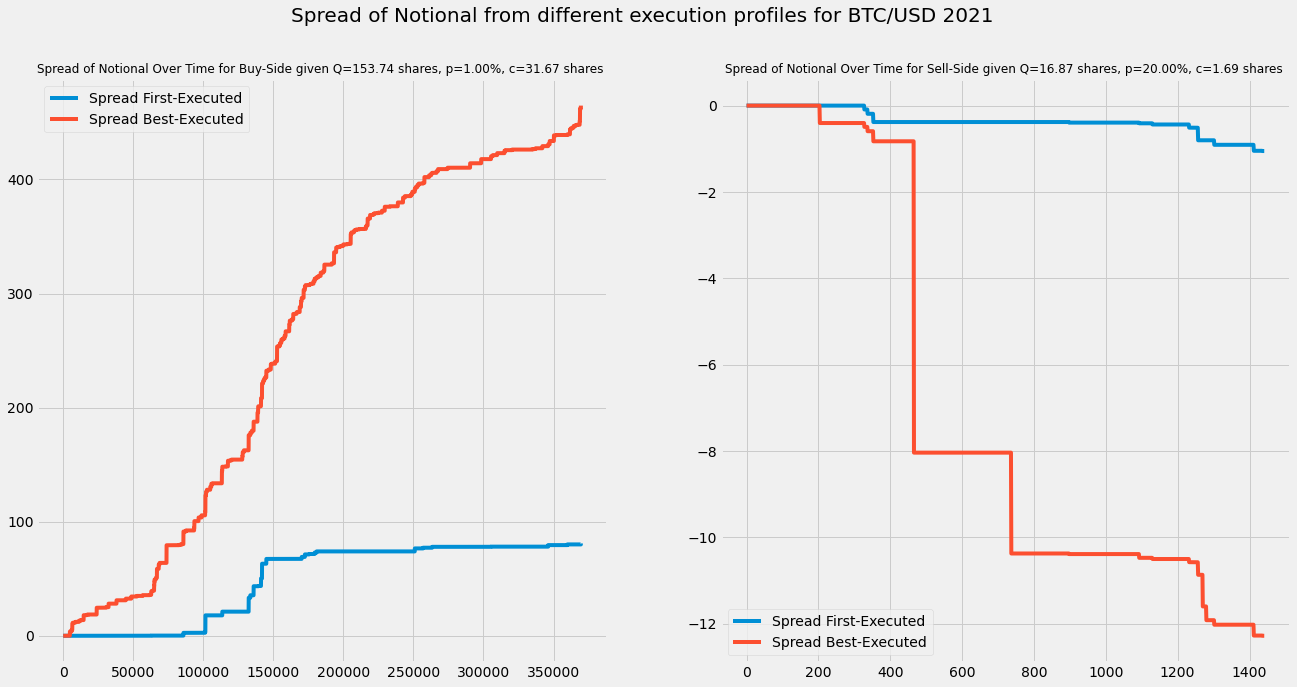

In [45]:
fig, axs = plt.subplots(1,2,figsize=(20,10))
plt.style.use('fivethirtyeight')
fig.suptitle('Spread of Notional from different execution profiles for BTC/USD 2021', fontsize = 20)

spread_exec_first_buy = df_buy_side['cumul_notional_first_$'] - df_buy_side['cumul_notional_exec_$']
spread_exec_best_buy = df_buy_side['cumul_notional_best_$'] - df_buy_side['cumul_notional_exec_$']

spread_exec_first_sell = (df_sell_side['cumul_notional_first_$'] - df_sell_side['cumul_notional_exec_$'])
spread_exec_best_sell =  (df_sell_side['cumul_notional_best_$'] - df_sell_side['cumul_notional_exec_$'])


axs[0].plot(spread_exec_first_buy, label = 'Spread First-Executed')
axs[0].plot(spread_exec_best_buy, label = 'Spread Best-Executed')
axs[0].set_title("Spread of Notional Over Time for Buy-Side given Q=153.74 shares, p=1.00%, c=31.67 shares ", fontsize = 12)
axs[0].legend()

axs[1].plot(spread_exec_first_sell, label = 'Spread First-Executed')
axs[1].plot(spread_exec_best_sell, label = 'Spread Best-Executed')
axs[1].set_title("Spread of Notional Over Time for Sell-Side given Q=16.87 shares, p=20.00%, c=1.69 shares ", fontsize = 12)
axs[1].legend()


In this graph what we observe is the difference between the notional over time for two different type scenario of execution prices. In the First-Executed pair the difference is between the actual execution of the VWAP simulation and the VWAP simulation where instead of going down the trade book when we engage the market, we fill in the order at the first price that is available. As for the left graphic where people are buying our shares, we see an improvement but a slow one over many trades (350k). While for the right graphic where we are buying, so we want a smaller notional. There are a few things important to note here, the first one being that the amount of trade orders is much smaller leaving room for a higher variance for the spread. The second one is that we are not interacting with the book order where usually if you instead of filling at the first price available you kept going down the book order, you'd get a worse price. 

This was one the main reason I wanted to analyze what would happen if we filled in the order immetiately at the current price versus going further the trade book. Clearly, in a real trading situation, going down the book order would make it worse and that is one of the principal concern of this assignment where we are investigating a VWAP. The intent was to show the limit of running an analysis only on the trade book and not the order book. 

As for the second type of spread, this shows the difference of notional over time if each time we engaged the market, instead of taking the worst price in the next 0.1s, we took the best price. While it seems to show more improvement on the left, it is important to see that the two are not on the same scale. Doing a quick analysis, I would actually assume greater benefit on the right one given an improvement of a notional of 12 over ~1400 orders versus ~450 over ~350k orders. We will be looking at more of these in the next section where the two sides will be scaled for each pairs.

# 3. Analyzing the Buy-Side and Sell-Side over the 3 pairs in 2018, 2021.

We'll start by cleaning and restructuring the dataframes as we did in section 2.

In [46]:
df_master_ = copy.deepcopy(df_master)

In [47]:
dfs_2018 = []
dfs_2021 = [] 
dfs = [dfs_2018, dfs_2021]

for i in range(len(df_master)):
    dfs_2018.append(df_master[i][0])
    dfs_2021.append(df_master[i][1])

dfs_2018_buy = []
dfs_2018_sell = []

dfs_2021_buy = []
dfs_2021_sell = []

for j in range(len(dfs)):
    for i in range(len(dfs_2018)):
        # Seed to be able to reproduce results
        np.random.seed(10*i + 7*j)
        
        df_buy = dfs[j][i][dfs[j][i]['Side']==1]
        df_sell = dfs[j][i][dfs[j][i]['Side']==-1]
        
        start_time_buy_idx = np.random.randint(0.25*df_buy.shape[0])
        start_time_sell_idx = np.random.randint(0.25*df_sell.shape[0])
        
        df_buy = df_buy[df_buy.index >= start_time_buy_idx]
        df_buy = df_buy.reset_index()
        df_buy.drop(['index'], inplace = True, axis = 1)
        df_sell = df_sell[df_sell.index >= start_time_sell_idx]
        df_sell = df_sell.reset_index()
        df_sell.drop(['index'], inplace = True, axis = 1)

        df_buy['time_btw_trades'][0] = 0 
        df_sell['time_btw_trades'][0] = 0 
        df_buy['time_from_start'] = df_buy['time_btw_trades'].cumsum()
        df_sell['time_from_start'] = df_sell['time_btw_trades'].cumsum()
        
        df_buy['size_cumulative'] = df_buy['SizeBillionths'].cumsum()
        df_sell['size_cumulative'] = df_sell['SizeBillionths'].cumsum()
        df_buy['trade_size'] = 0 
        df_sell['trade_size'] = 0 
        df_buy['trade_price_exec'] = 0 
        df_sell['trade_price_exec'] = 0 
        df_buy['trade_best_price'] = 0 
        df_sell['trade_best_price'] = 0 
        
        if j < 1:
            dfs_2018_buy.append(df_buy)
            dfs_2018_sell.append(df_sell)
        else:
            dfs_2021_buy.append(df_buy)
            dfs_2021_sell.append(df_sell)



In [48]:
dfs_2021_sell[2].describe()

,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,time_btw_trades,time_from_start,size_cumulative,trade_size,trade_price_exec,trade_best_price
count,1.1669e+06,1.1669e+06,1.1669e+06,1166926.0,1.1669e+06,1.1669e+06,1.1669e+06,1166926.0,1166926.0,1166926.0
mean,1.6186e+18,5.9530e+10,6.9619e+07,-1.0,1.9463e+08,1.3381e+14,3.9833e+13,0.0,0.0,0.0
std,2.3038e+14,3.2859e+09,2.7395e+08,0.0,3.7819e+08,5.9307e+13,2.3522e+13,0.0,0.0,0.0
min,1.6181e+18,5.1300e+10,1.0000e+01,-1.0,0.0000e+00,0.0000e+00,1.0113e+06,0.0,0.0,0.0
25%,1.6184e+18,5.6090e+10,2.2125e+06,-1.0,0.0000e+00,8.8386e+13,1.9077e+13,0.0,0.0,0.0
50%,1.6186e+18,6.0336e+10,9.7500e+06,-1.0,4.5545e+07,1.4263e+14,3.8979e+13,0.0,0.0,0.0
75%,1.6188e+18,6.2664e+10,3.8000e+07,-1.0,2.3055e+08,1.8004e+14,6.0223e+13,0.0,0.0,0.0
max,1.6190e+18,6.4897e+10,8.1091e+10,-1.0,1.5871e+10,2.2712e+14,8.1241e+13,0.0,0.0,0.0


## 3.1 Comparaison of pairs for fixed set of inputs.

In [49]:
p = 0.1
Q = 15e9
c = Q/(50*p)
print("Parameters for the VWAP: Q={:.2f} shares, p={:.2f}%, c={:.2f} shares, Number of Time partcipating in Market: 50".format(Q/1e9, p*100, c/1e9))

Parameters for the VWAP: Q=15.00 shares, p=10.00%, c=3.00 shares, Number of Time partcipating in Market: 50


In [50]:
dfs_2018_buy_vwap = []
dfs_2018_sell_vwap = []

dfs_2021_buy_vwap = []
dfs_2021_sell_vwap = []


for i in range(len(dfs_2018)):
    dfs_2018_buy_vwap.append(VWAP_simulation(Q, c, p, dfs_2018_buy[i]))
    dfs_2018_sell_vwap.append(VWAP_simulation(Q, c, p, dfs_2018_sell[i]))
    dfs_2021_buy_vwap.append(VWAP_simulation(Q, c, p, dfs_2021_buy[i]))
    dfs_2021_sell_vwap.append(VWAP_simulation(Q, c, p, dfs_2021_sell[i]))


In [51]:
df_vwap = [dfs_2018_buy_vwap, dfs_2018_sell_vwap, dfs_2021_buy_vwap, dfs_2021_sell_vwap]

years = "2018 2021".split()
pairs = "ETH/USD ETH/BTC BTC/USD".split()
side = "BUY SELL".split()

col_names = [y + "_" + s + "_" + p for y in years for s in side for p in pairs]
idx = ['Participation Rate(%)' ,'Ratio Sub-Optimal Trades', "Average Time Spent between Trades(s)", "Number of Participation", "Number of Trades"]

pairs_df = pd.DataFrame(index = idx, columns = col_names)

In [52]:
for i in range(len(df_vwap)):
    for j in range(len(dfs_2018_buy_vwap)):
        
        df_temp, num_of_participation, size_to_liquidate, participation_rate, log_trades, trades_in_flurry, first_trade_participation = df_vwap[i][j]
        
        col = col_names[3*i+j]
        
        time_of_first_trades = []
        for timestamp, trades in first_trade_participation.items():
            time_of_first_trades.append(timestamp)
        time_of_first_trades = np.array(sorted(time_of_first_trades))
        average_time_btw_trades = 1e-9 * (time_of_first_trades[1:] - time_of_first_trades[:-1]).mean()
        
        sub_optimal = len(trades_in_flurry)/df_temp[df_temp['trade_size']!=0].count()[0]
        pairs_df[col].loc['Participation Rate(%)'] = 100*participation_rate
        pairs_df[col].loc['Ratio Sub-Optimal Trades'] = sub_optimal
        pairs_df[col].loc["Average Time Spent between Trades(s)"] = average_time_btw_trades
        pairs_df[col].loc["Number of Participation"] = num_of_participation
        pairs_df[col].loc["Number of Trades"] = df_temp[df_temp['trade_size']!=0].count()[0]
        
pairs_df.T # Realized after making the dataframe easier to read if flip

,Participation Rate(%),Ratio Sub-Optimal Trades,Average Time Spent between Trades(s),Number of Participation,Number of Trades
2018_BUY_ETH/USD,9.323,0.0,35.9267,50,152
2018_BUY_ETH/BTC,8.6316,0.0,25.8516,50,58
2018_BUY_BTC/USD,9.0256,0.0,65.1243,50,119
2018_SELL_ETH/USD,7.1459,0.0,16.3977,50,61
2018_SELL_ETH/BTC,8.792,0.0,178.4417,50,174
2018_SELL_BTC/USD,9.95,0.0,148.253,50,141
2021_BUY_ETH/USD,9.3546,0.0,9.1251,50,146
2021_BUY_ETH/BTC,6.2324,0.0056,32.6621,50,179
2021_BUY_BTC/USD,9.9872,0.0026,56.6917,50,387
2021_SELL_ETH/USD,5.5494,0.0168,5.1194,50,119


For all the dates in 2018, we observe that none of our trades was done sub-optimally while in 2021 there is significant amount of trades done sup-optimally. This happens because the liquidity and volume in 2018 was smaller than 2021, so we didn't happen to be executing any of our trades in moments where there were burst of trades happening forcing us to take a worse price. Worth noting how the average time spent sitting between trades in 2018 is on average higher than in 2021 reflecting the smaller amount of volume being traded. 

Although, for "2021_BUY_ETH/USD" there is a small average time spent between trades we still have none that were done sub-optimally, this could be due to the high variance of the ratio of sub-optimal traded given the low amount of trades, the range of trades being sub-optimal is from 20 basis points to 600 basis points. 

In each case, the algorithm seems to properly have entered the market 50 times. 

The participation rate seems to wildly vary between 5.55% and 9.99% reflecting of the high variance of notional size in the market and small sample for limiting our observation for a small window of time. The sell side also seems to have higher average time spent between trades, reflecting more liquidity on one side of the book order which is reasonable knowing that the prices of ETH and BTC generally trended up between those periods.

The number of trades we participate also wildly changes over the different pair/period but it seems like there are a greater number of trades happening in 2021 due to the higher frequency of trades with smaller notional value. The rows where the number of trades is highest tend to have a participation rate closer to the goal.


In [53]:
for i in range(len(df_vwap)):
    for j in range(len(dfs_2018_buy_vwap)):
        if j == 1:
            transaction_cost = 0.001
        else:
            transaction_cost = 0.005
        df_vwap[i][j][0]['trade_notional_first_$'] = ((1e-15)*df_vwap[i][j][0]['trade_size']).mul(df_vwap[i][j][0]['PriceMillionths']) * (1+transaction_cost)
        df_vwap[i][j][0]['trade_notional_exec_$'] = ((1e-15)*df_vwap[i][j][0]['trade_size']).mul(df_vwap[i][j][0]['trade_price_exec']) * (1+transaction_cost)
        df_vwap[i][j][0]['trade_notional_best_$'] = ((1e-15)*df_vwap[i][j][0]['trade_size']).mul(df_vwap[i][j][0]['trade_best_price']) * (1+transaction_cost)

        df_vwap[i][j][0]['cumul_notional_first_$'] = df_vwap[i][j][0]['trade_notional_first_$'].cumsum()
        df_vwap[i][j][0]['cumul_notional_exec_$'] = df_vwap[i][j][0]['trade_notional_exec_$'].cumsum()
        df_vwap[i][j][0]['cumul_notional_best_$'] = df_vwap[i][j][0]['trade_notional_best_$'].cumsum()

Let's do a similar plot of spreads of different execution strategy at the end section 2 for the different pairs in 2018 and 2021.

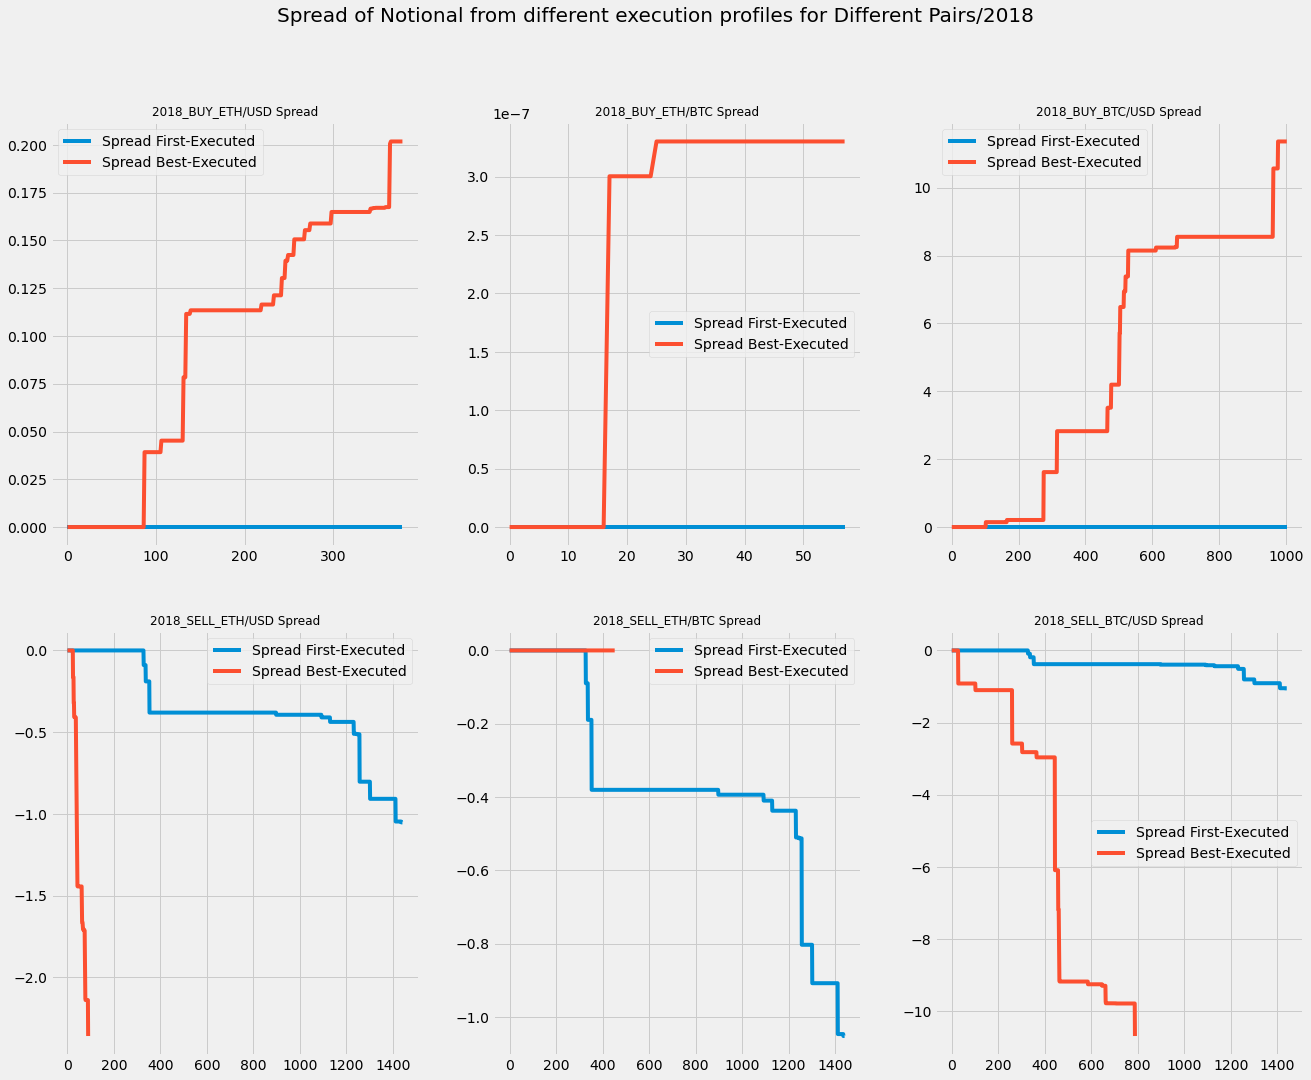

In [54]:
fig, axs = plt.subplots(2,3,figsize=(20,16))
plt.style.use('fivethirtyeight')
fig.suptitle('Spread of Notional from different execution profiles for Different Pairs/2018', fontsize = 20)

for j in range(len(dfs_2018_buy_vwap)):
    df_buy_side = dfs_2018_buy_vwap[j][0]
    df_sell_side = dfs_2018_sell_vwap[j][0]
    
    spread_exec_first_buy = df_buy_side['cumul_notional_first_$'] - df_buy_side['cumul_notional_exec_$']
    spread_exec_best_buy = df_buy_side['cumul_notional_best_$'] - df_buy_side['cumul_notional_exec_$']

    aspread_exec_first_sell = (df_sell_side['cumul_notional_first_$'] - df_sell_side['cumul_notional_exec_$'])
    spread_exec_best_sell =  (df_sell_side['cumul_notional_best_$'] - df_sell_side['cumul_notional_exec_$'])


    axs[0,j].plot(spread_exec_first_buy, label = 'Spread First-Executed')
    axs[0,j].plot(spread_exec_best_buy, label = 'Spread Best-Executed')
    axs[0,j].set_title("{} Spread".format(col_names[j]), fontsize = 12)
    axs[0,j].legend()

    axs[1,j].plot(spread_exec_first_sell, label = 'Spread First-Executed')
    axs[1,j].plot(spread_exec_best_sell, label = 'Spread Best-Executed')
    axs[1,j].set_title("{} Spread".format(col_names[j+3]), fontsize = 12)
    axs[1,j].legend()

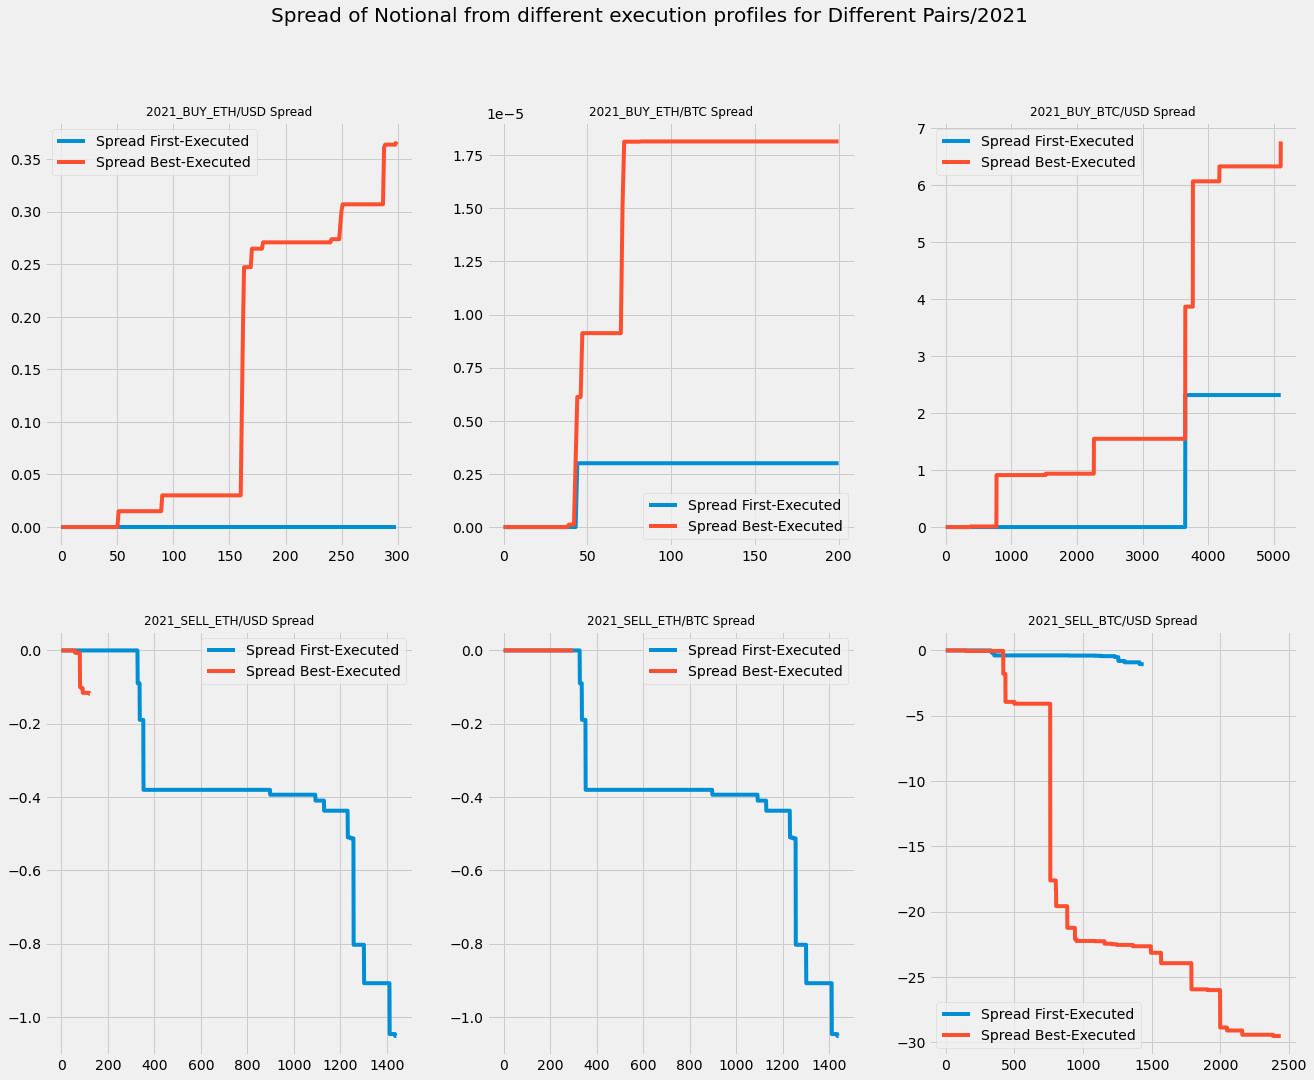

In [55]:
fig, axs = plt.subplots(2,3,figsize=(20,16))
plt.style.use('fivethirtyeight')
fig.suptitle('Spread of Notional from different execution profiles for Different Pairs/2021', fontsize = 20)

for j in range(len(dfs_2021_buy_vwap)):
    df_buy_side = dfs_2021_buy_vwap[j][0]
    df_sell_side = dfs_2021_sell_vwap[j][0]
    
    spread_exec_first_buy = df_buy_side['cumul_notional_first_$'] - df_buy_side['cumul_notional_exec_$']
    spread_exec_best_buy = df_buy_side['cumul_notional_best_$'] - df_buy_side['cumul_notional_exec_$']

    aspread_exec_first_sell = (df_sell_side['cumul_notional_first_$'] - df_sell_side['cumul_notional_exec_$'])
    spread_exec_best_sell =  (df_sell_side['cumul_notional_best_$'] - df_sell_side['cumul_notional_exec_$'])


    axs[0,j].plot(spread_exec_first_buy, label = 'Spread First-Executed')
    axs[0,j].plot(spread_exec_best_buy, label = 'Spread Best-Executed')
    axs[0,j].set_title("{} Spread".format(col_names[j+6]), fontsize = 12)
    axs[0,j].legend()

    axs[1,j].plot(spread_exec_first_sell, label = 'Spread First-Executed')
    axs[1,j].plot(spread_exec_best_sell, label = 'Spread Best-Executed')
    axs[1,j].set_title("{} Spread".format(col_names[j+9]), fontsize = 12)
    axs[1,j].legend()

In all 6 cases of First-Executed spreads, we get a worst outcome by executing at the first price sold then subsequent prices in the market. We've already noted why this wouldn't make sense in an actual trading system considering we'd be pushing the book order and get worse price if we executed at subsequent prices. Perhaps the reason is that since the liquidity on the buy-side is higher than on the sell-side, and that the prices of the cryptotokens were generally trending up that the more you'd wait to sell, the better a price you'd get than if you sold right away. 

The Buy-Side spread between the best strategy and execution for ETH/BTC in 2018 is almost 0 but BTC/USD and ETH/USD 2018 seemed to have a positive effect from using the best price available in the next 0.1ns. Considering that the spread among those two is pretty much null for that strategy, and a similar trend in both, it may have been possible given no transaction cost to participate in arbitrage between the two cryptocurrents using USD.

Note how much the Best strategy is better than the executed one for BTC in 2021 compares to the other graphics. Considering how bullish BTC has been in 2021 and the higher liquidity, it seems faire to see a significant boost to the notional by taking the best price in the next 0.1ns window.

Let's now look at the distribution between trades for the various pairs/years.

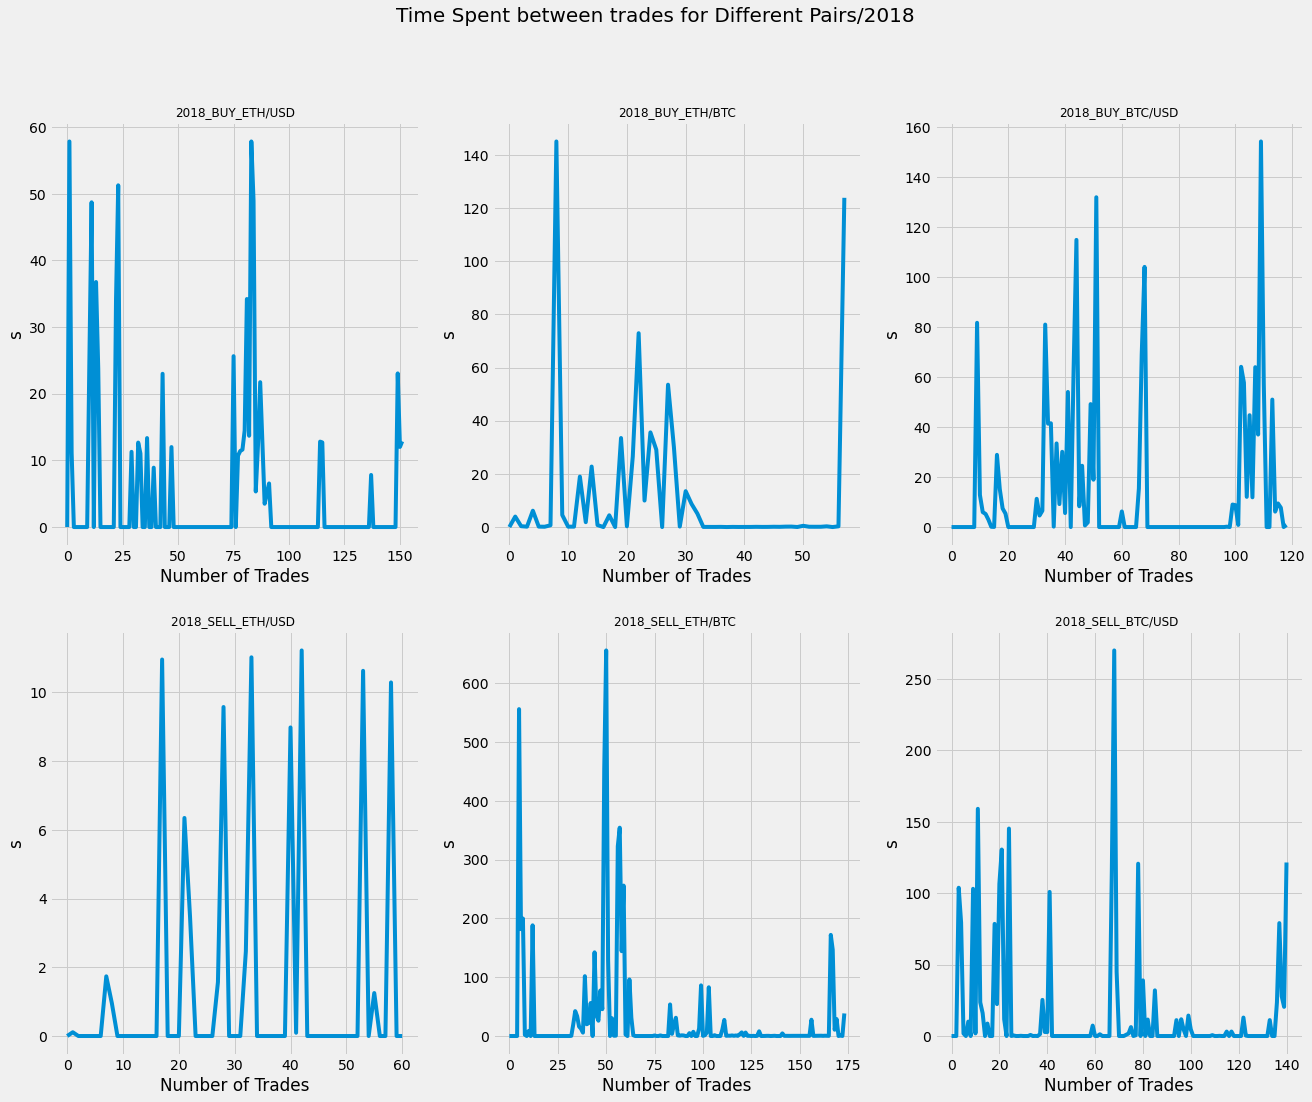

In [56]:
fig, axs = plt.subplots(2,3,figsize=(20,16))
plt.style.use('fivethirtyeight')
fig.suptitle('Time Spent between trades for Different Pairs/2018', fontsize = 20)

for j in range(len(dfs_2018_buy_vwap)):
    df_buy_side = dfs_2018_buy_vwap[j][0]
    df_sell_side = dfs_2018_sell_vwap[j][0]
    
    x_buy = df_buy_side[df_buy_side['trade_size']!=0].reset_index().index
    y_buy = df_buy_side[df_buy_side['trade_size']!=0]['time_from_start'].diff().fillna(0)*1e-9

    x_sell = df_sell_side[df_sell_side['trade_size']!=0].reset_index().index
    y_sell = df_sell_side[df_sell_side['trade_size']!=0]['time_from_start'].diff().fillna(0)*1e-9


    axs[0,j].plot(x_buy, y_buy)
    axs[0,j].set_title("{}".format(col_names[j]), fontsize = 12)
    axs[0,j].set_xlabel('Number of Trades')
    axs[0,j].set_ylabel('s')

    axs[1,j].plot(x_sell, y_sell)
    axs[1,j].set_title("{} ".format(col_names[j+3]), fontsize = 12)
    axs[1,j].set_xlabel('Number of Trades')
    axs[1,j].set_ylabel('s')


Interestingly, it looks like the time spent not interacting with the market when waiting for the chunk side at worst is smaller for ETH/USD pair. There's also a long time period in ETH/BTC where in order to fill in our required size of trading, we had to execute a lot of small trades ~(50-30) trades.

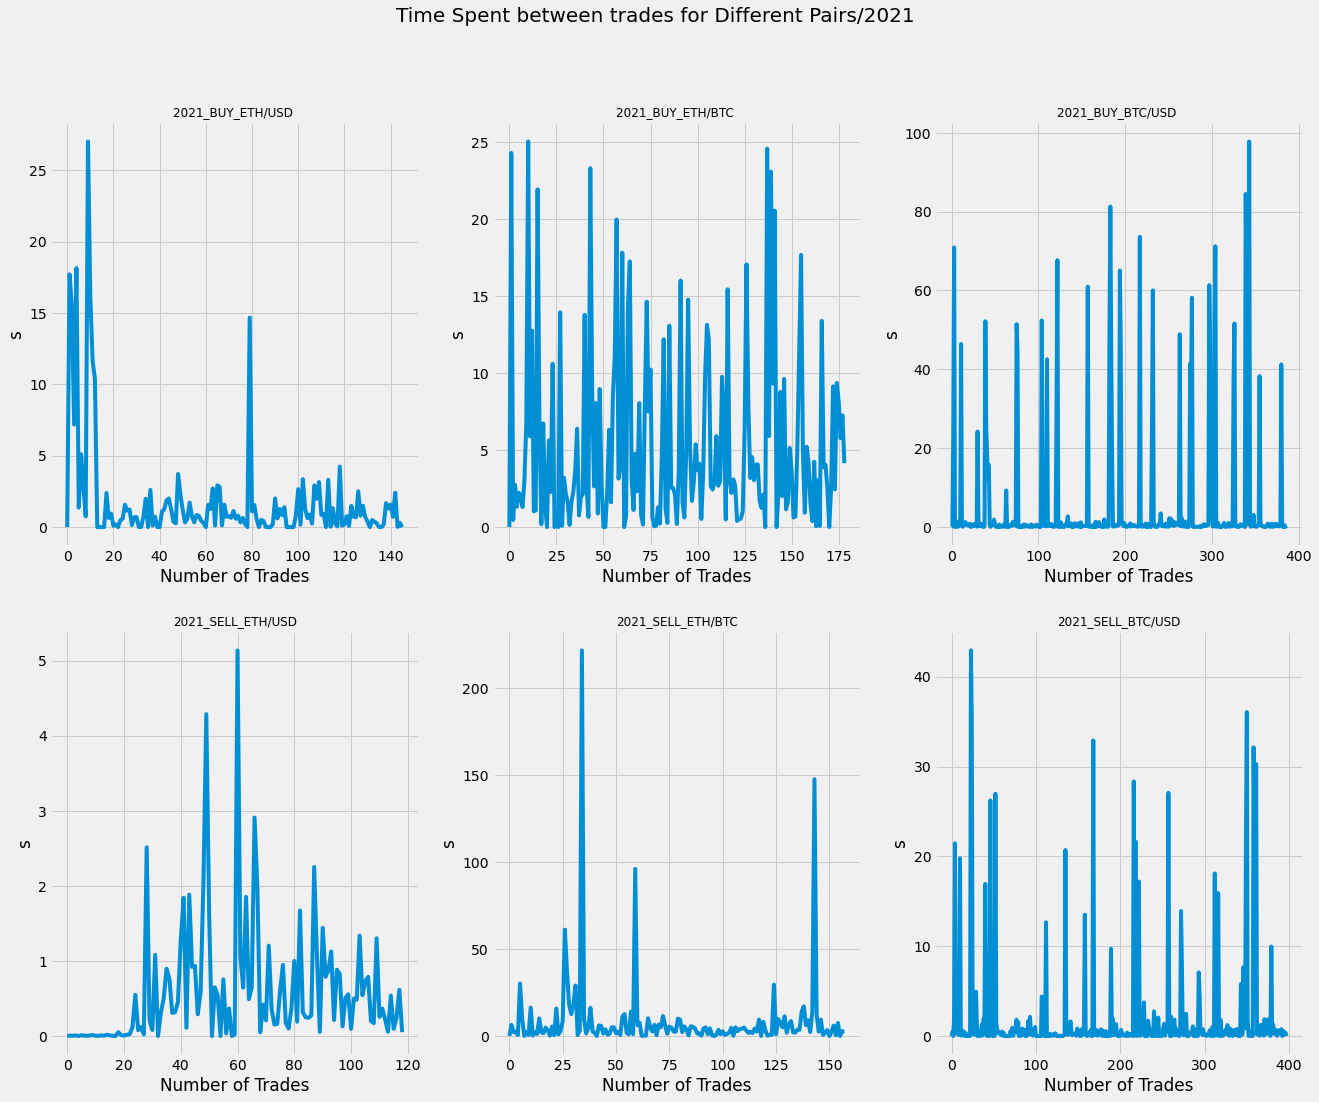

In [57]:
fig, axs = plt.subplots(2,3,figsize=(20,16))
plt.style.use('fivethirtyeight')
fig.suptitle('Time Spent between trades for Different Pairs/2021', fontsize = 20)

for j in range(len(dfs_2021_buy_vwap)):
    df_buy_side = dfs_2021_buy_vwap[j][0]
    df_sell_side = dfs_2021_sell_vwap[j][0]
    
    x_buy = df_buy_side[df_buy_side['trade_size']!=0].reset_index().index
    y_buy = df_buy_side[df_buy_side['trade_size']!=0]['time_from_start'].diff().fillna(0)*1e-9

    x_sell = df_sell_side[df_sell_side['trade_size']!=0].reset_index().index
    y_sell = df_sell_side[df_sell_side['trade_size']!=0]['time_from_start'].diff().fillna(0)*1e-9


    axs[0,j].plot(x_buy, y_buy)
    axs[0,j].set_title("{} ".format(col_names[j+6]), fontsize = 12)
    axs[0,j].set_xlabel('Number of Trades')
    axs[0,j].set_ylabel('s')

    axs[1,j].plot(x_sell, y_sell)
    axs[1,j].set_title("{}".format(col_names[j+9]), fontsize = 12)
    axs[1,j].set_xlabel('Number of Trades')
    axs[1,j].set_ylabel('s')


These graphs confirms what we had previously expected that there is more liquidity in 2021 than in 2018 so the time spent waiting between trades is generally smaller and the extremes are not as bad. It also seems like we had to execute a lot more smaller trades considering the total number of trades is larger. With the popularity of cryptotockens, paired with the ease of apps to trade very small sizes of these cryptotokens, it is not surprising to see that more people would trade or buy smaller quantities. 

Let's look how our participation rate changes over time.

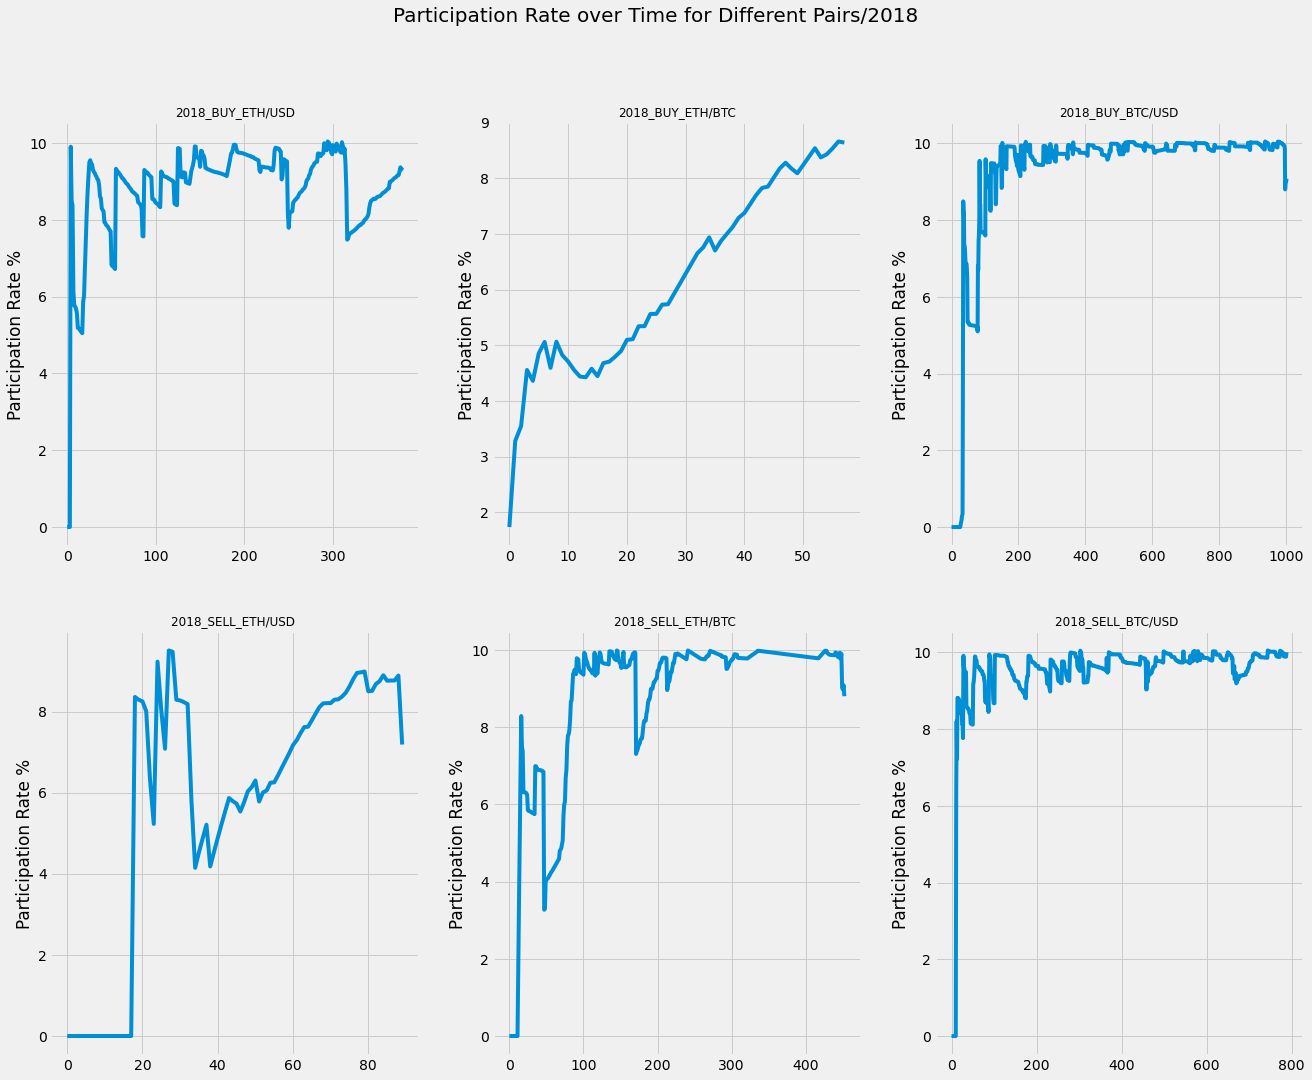

In [58]:
fig, axs = plt.subplots(2,3,figsize=(20,16))
plt.style.use('fivethirtyeight')
fig.suptitle('Participation Rate over Time for Different Pairs/2018', fontsize = 20)

for j in range(len(dfs_2018_buy_vwap)):
    df_buy_side = dfs_2018_buy_vwap[j][0]
    df_sell_side = dfs_2018_sell_vwap[j][0]
    

    x_buy = df_buy_side.index
    y_buy = 100*df_buy_side['cumul_notional_exec_$']/((1e-15*df_buy_side['PriceMillionths'] * df_buy_side['SizeBillionths']).cumsum())

    x_sell = df_sell_side.index
    y_sell = 100*df_sell_side['cumul_notional_exec_$']/((1e-15*df_sell_side['PriceMillionths'] * df_sell_side['SizeBillionths']).cumsum())


    axs[0,j].plot(x_buy, y_buy)
    axs[0,j].set_title("{}".format(col_names[j]), fontsize = 12)
    axs[0,j].set_ylabel('Participation Rate %')

    axs[1,j].plot(x_sell, y_sell)
    axs[1,j].set_title("{} ".format(col_names[j+3]), fontsize = 12)
    axs[1,j].set_ylabel('Participation Rate %')

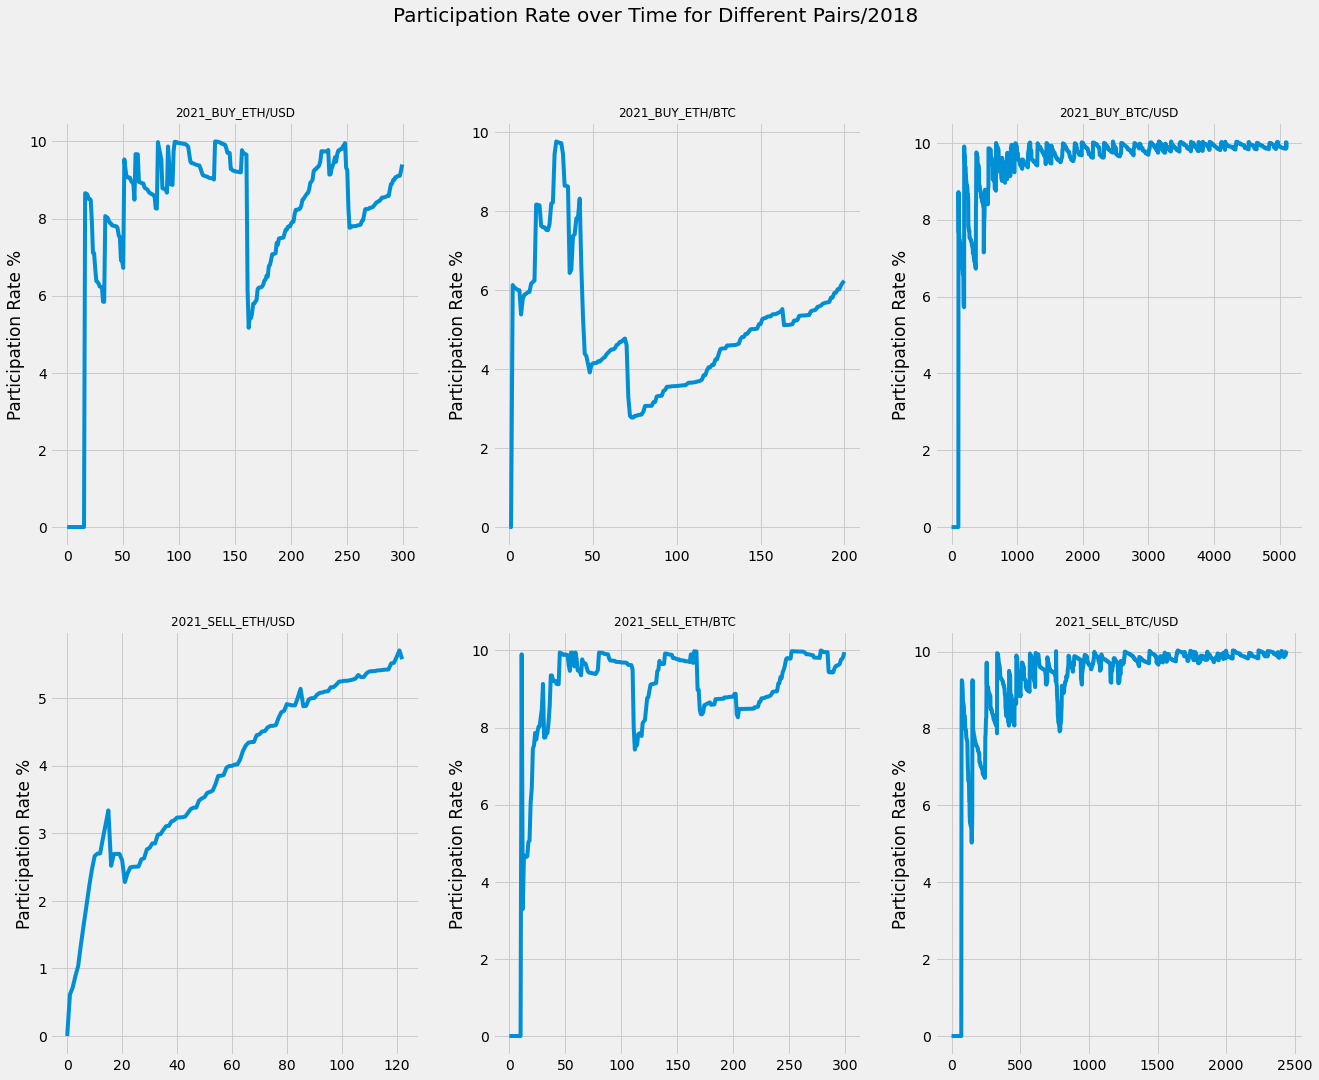

In [59]:
fig, axs = plt.subplots(2,3,figsize=(20,16))
plt.style.use('fivethirtyeight')
fig.suptitle('Participation Rate over Time for Different Pairs/2018', fontsize = 20)

for j in range(len(dfs_2021_buy_vwap)):
    df_buy_side = dfs_2021_buy_vwap[j][0]
    df_sell_side = dfs_2021_sell_vwap[j][0]
    

    x_buy = df_buy_side.index
    y_buy = 100*df_buy_side['cumul_notional_exec_$']/((1e-15*df_buy_side['PriceMillionths'] * df_buy_side['SizeBillionths']).cumsum())

    x_sell = df_sell_side.index
    y_sell = 100*df_sell_side['cumul_notional_exec_$']/((1e-15*df_sell_side['PriceMillionths'] * df_sell_side['SizeBillionths']).cumsum())


    axs[0,j].plot(x_buy, y_buy)
    axs[0,j].set_title("{}".format(col_names[j+6]), fontsize = 12)
    axs[0,j].set_ylabel('Participation Rate %')

    axs[1,j].plot(x_sell, y_sell)
    axs[1,j].set_title("{} ".format(col_names[j+9]), fontsize = 12)
    axs[1,j].set_ylabel('Participation Rate %')

For the pairs and years where the number of trades is high ,we tend to converge to our participation rate of 10%, but for those with less trades there is higher variance which explains some of odd results we had in the table. Given a longer liquidation period, we would be looking closer to our target participation rate. This is important to take into consideration if we want to actually get to our target participation rate, if we are looking at a smaller fraction of time to liquidate, we should be aiming at a higher percentage based on volume frequency and size of the orders. Like ETH/USD 2021 Sell-Side, the number of trades is low compared to the number of time we want to be participating in the market. If we look at the time in between trades it is also very low. 

Next, we've been talking a lot about the volume/size/notional difference between 2018 and 2021. Let's get a closer look.

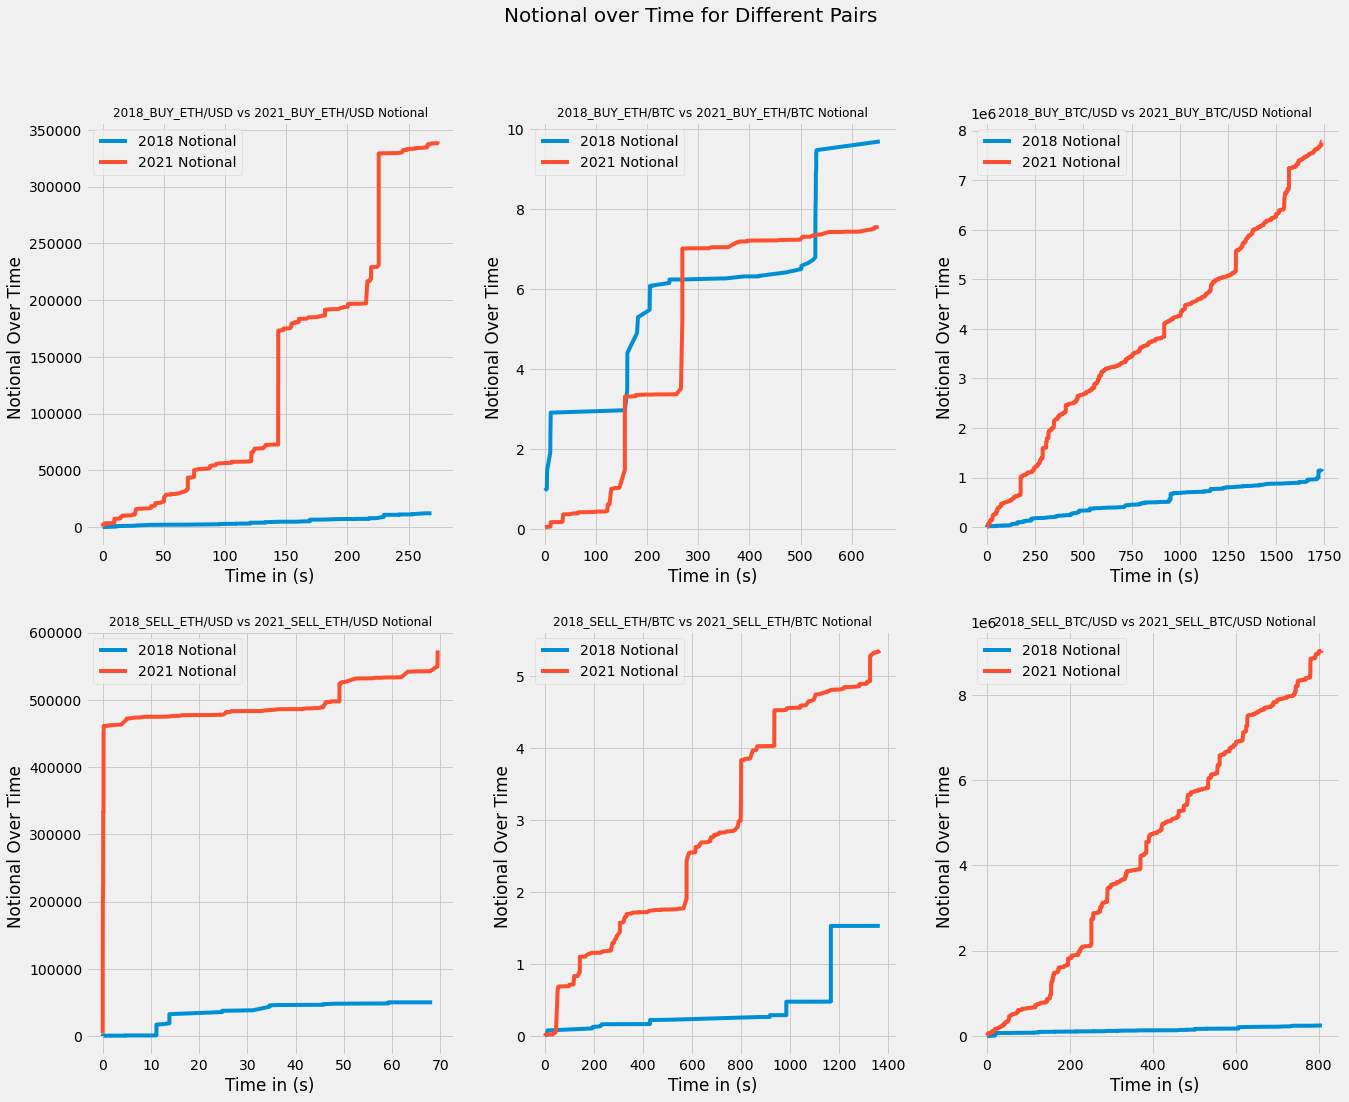

In [60]:
fig, axs = plt.subplots(2,3,figsize=(20,16))
plt.style.use('fivethirtyeight')
fig.suptitle('Notional over Time for Different Pairs', fontsize = 20)

for i in range(len(dfs)):
    for j in range(len(dfs_2021_buy_vwap)):
    
        if i == 0:
            df_2018 = dfs_2018_buy_vwap[j][0]
            df_2021 = dfs_2021_buy_vwap[j][0]
        else:
            df_2018 = dfs_2018_sell_vwap[j][0]
            df_2021 = dfs_2021_sell_vwap[j][0]
        # We'll compare the same time period for both years 
        if df_2018['time_from_start'].iloc[-1] < df_2021['time_from_start'].iloc[-1]:
            df_2021 = df_2021[df_2021['time_from_start'] <= df_2018['time_from_start'].iloc[-1]]

        else:
            df_2018 = df_2018[df_2018['time_from_start'] <= df_2021['time_from_start'].iloc[-1]]
            
        x_2018 = 1e-9*df_2018['time_from_start'] - df_2018['time_from_start'].iloc[0]
        x_2021 = 1e-9*df_2021['time_from_start'] - df_2021['time_from_start'].iloc[0]
        
        y_2018 =  (1e-15*df_2018['PriceMillionths'] * df_2018['SizeBillionths']).cumsum()
        y_2021 =  (1e-15*df_2021['PriceMillionths'] * df_2021['SizeBillionths']).cumsum()

        if i < 1:
            axs[i,j].plot(x_2018, y_2018, label = '2018 Notional')
            axs[i,j].plot(x_2021, y_2021, label = '2021 Notional')
            axs[i,j].set_title("{} vs {} Notional".format(col_names[j], col_names[6+j]), fontsize = 12)
            axs[i,j].set_ylabel('Notional Over Time ')
            axs[i,j].set_xlabel('Time in (s)')
            axs[i,j].legend()
            
        else:
            axs[i,j].plot(x_2018, y_2018, label = '2018 Notional')
            axs[i,j].plot(x_2021, y_2021, label = '2021 Notional')
            axs[i,j].set_title("{} vs {} Notional".format(col_names[3+j], col_names[9+j]), fontsize = 12)
            axs[i,j].set_ylabel('Notional Over Time ')
            axs[i,j].set_xlabel('Time in (s)')
            axs[i,j].legend()

Other than the trading between ETH/BTC in 2018 the notional in 2021 is much larger than it was in 2018 for our samples which confirmed out intuition that there is more activity in 2021 market than in 2018 for both the Buy and Sell side of things. It is also worth noting how much the time frame changes when trading the goal was to trade the same quantity and have the same participation rate in the market. For each date/pair we have random sample from our dataset so it really shows how inconsistent and how the variance is high for the frequency of volume/size in our training sample.

# 4. Comparaison changing parameters

In this section we will look at comparing some metrics for various parameters. We've already looked more in-depth at various metrics in section 3 for a given set of parameters so we will focus on the first table of section 3 for various parameters.

In [61]:
def generate_table(q,chunk,p, master_df):
    
    df_master_2 = copy.deepcopy(master_df)
    c = q/(p*chunk)
    dfs_2018_ = []
    dfs_2021_ = [] 
    
    for v in range(len(df_master_)):
        dfs_2018_.append(df_master_2[v][0])
        dfs_2021_.append(df_master_2[v][1])
        
    df_  = [dfs_2018_, dfs_2021_]
    dfs_2018_buy_ = []
    dfs_2018_sell_ = []

    dfs_2021_buy_ = []
    dfs_2021_sell_ = []

    for j in range(len(df_)):
        for i in range(len(dfs_2018_)): 
            # Seed to be able to reproduce results
            np.random.seed(10*i + 7*j)
           # np.random.seed(int(p+q+c)+10*i + 7*j)

            df_buy_ = df_[j][i][df_[j][i]['Side']==1]
            df_sell_ = df_[j][i][df_[j][i]['Side']==-1]

            start_time_buy_idx_ = np.random.randint(0.25*df_buy_.shape[0])
            start_time_sell_idx_ = np.random.randint(0.25*df_sell_.shape[0])

            df_buy_ = df_buy_[df_buy_.index >= start_time_buy_idx_]
            df_buy_ = df_buy_.reset_index()
            df_buy_.drop(['index'], inplace = True, axis = 1)
            df_sell_ = df_sell_[df_sell_.index >= start_time_sell_idx_]
            df_sell_ = df_sell_.reset_index()
            df_sell_.drop(['index'], inplace = True, axis = 1)

            df_buy_['time_btw_trades'][0] = 0 
            df_sell_['time_btw_trades'][0] = 0 
            df_buy_['time_from_start'] = df_buy_['time_btw_trades'].cumsum()
            df_sell_['time_from_start'] = df_sell_['time_btw_trades'].cumsum()

            df_buy_['size_cumulative'] = df_buy_['SizeBillionths'].cumsum()
            df_sell_['size_cumulative'] = df_sell_['SizeBillionths'].cumsum()
            df_buy_['trade_size'] = 0 
            df_sell_['trade_size'] = 0 
            df_buy_['trade_price_exec'] = 0 
            df_sell_['trade_price_exec'] = 0 
            df_buy_['trade_best_price'] = 0 
            df_sell_['trade_best_price'] = 0 

            if j < 1:
                dfs_2018_buy_.append(df_buy_)
                dfs_2018_sell_.append(df_sell_)
            else:
                dfs_2021_buy_.append(df_buy_)
                dfs_2021_sell_.append(df_sell_)
                
    dfs_2018_buy_vwap_ = []
    dfs_2018_sell_vwap_ = []

    dfs_2021_buy_vwap_ = []
    dfs_2021_sell_vwap_ = []
    
    Q = q
    for k in range(len(dfs_2018_)):
        dfs_2018_buy_vwap_.append(VWAP_simulation(Q, c, p, dfs_2018_buy_[k]))
        dfs_2018_sell_vwap_.append(VWAP_simulation(Q, c, p, dfs_2018_sell_[k]))
        dfs_2021_buy_vwap_.append(VWAP_simulation(Q, c, p, dfs_2021_buy_[k]))
        dfs_2021_sell_vwap_.append(VWAP_simulation(Q, c, p, dfs_2021_sell_[k]))
        

    df_vwap_ = [dfs_2018_buy_vwap_, dfs_2018_sell_vwap_, dfs_2021_buy_vwap_, dfs_2021_sell_vwap_]

    years = "2018 2021".split()
    pairs = "ETH/USD ETH/BTC BTC/USD".split()
    side = "BUY SELL".split()

    col_names = [y + "_" + s + "_" + p for y in years for s in side for p in pairs]
    idx = ['Participation Rate(%)' ,'Ratio Sub-Optimal Trades', "Average Time Spent between Trades(s)", "Number of Participation", "Number of Trades"]

    pairs_df_ = pd.DataFrame(index = idx, columns = col_names)
    
    for i in range(len(df_vwap_)):
        for j in range(len(dfs_2018_buy_vwap_)):

            df_temp, num_of_participation, size_to_liquidate, participation_rate, log_trades, trades_in_flurry, first_trade_participation = df_vwap_[i][j]

            col = col_names[3*i+j]

            time_of_first_trades = []
            for timestamp, trades in first_trade_participation.items():
                time_of_first_trades.append(timestamp)
            time_of_first_trades = np.array(sorted(time_of_first_trades))
            average_time_btw_trades = 1e-9 * (time_of_first_trades[1:] - time_of_first_trades[:-1]).mean()

            sub_optimal = len(trades_in_flurry)/df_temp[df_temp['trade_size']!=0].count()[0]
            pairs_df[col].loc['Participation Rate(%)'] = 100*participation_rate
            pairs_df[col].loc['Ratio Sub-Optimal Trades'] = sub_optimal
            pairs_df[col].loc["Average Time Spent between Trades(s)"] = average_time_btw_trades
            pairs_df[col].loc["Number of Participation"] = num_of_participation
            pairs_df[col].loc["Number of Trades"] = df_temp[df_temp['trade_size']!=0].count()[0]

    return pairs_df.T


Let's start with similar values as the previous section but instead of 10% participation, we'll have 5% and interact with market 200 times. 

In [62]:
p_5 = generate_table(15e9, 200, 0.05, df_master_)
p_5

,Participation Rate(%),Ratio Sub-Optimal Trades,Average Time Spent between Trades(s),Number of Participation,Number of Trades
2018_BUY_ETH/USD,4.5605,0.0,19.2755,200,358
2018_BUY_ETH/BTC,2.3515,0.0044,44.2449,200,228
2018_BUY_BTC/USD,4.9845,0.0,25.23,200,357
2018_SELL_ETH/USD,1.7551,0.0036,14.7358,200,275
2018_SELL_ETH/BTC,2.6008,0.0,94.7849,200,298
2018_SELL_BTC/USD,4.9965,0.0027,52.321,200,377
2021_BUY_ETH/USD,4.9991,0.005,6.0919,200,401
2021_BUY_ETH/BTC,4.1406,0.0023,18.0315,200,436
2021_BUY_BTC/USD,4.999,0.0076,22.9821,200,654
2021_SELL_ETH/USD,2.3219,0.054,4.3651,200,352


Let's now decrease the participation to only 1%

In [63]:
p_01=  generate_table(15e9, 200, 0.01, df_master_)
p_01

,Participation Rate(%),Ratio Sub-Optimal Trades,Average Time Spent between Trades(s),Number of Participation,Number of Trades
2018_BUY_ETH/USD,0.9993,0.0,52.1672,200,217
2018_BUY_ETH/BTC,1.0,0.0,82.0908,200,221
2018_BUY_BTC/USD,0.9998,0.0,127.9386,200,240
2018_SELL_ETH/USD,0.9536,0.008,23.9089,200,250
2018_SELL_ETH/BTC,0.9835,0.0,428.0161,200,250
2018_SELL_BTC/USD,0.9997,0.0126,134.8103,200,238
2021_BUY_ETH/USD,0.9999,0.008,30.2128,200,251
2021_BUY_ETH/BTC,0.985,0.0033,72.1866,200,299
2021_BUY_BTC/USD,1.0,0.0448,110.1537,200,402
2021_SELL_ETH/USD,0.9194,0.0942,9.9036,200,276


As the participation rate goes down, by interacting less with the market there it is easier to get close to the % we want. The average time in the market seems to be going up which makes sense since we interact less with the market. Let's fix Q, c, and change p over time and see how the participation rate and ratio of sub-optimal trades changes over the parameters. 

In [64]:
p_arr = np.array([1,2,5,10,15,20,25,30,35,40,45,50])/100
tables_arr = [generate_table(15e9, 200, p, df_master_) for p in p_arr]

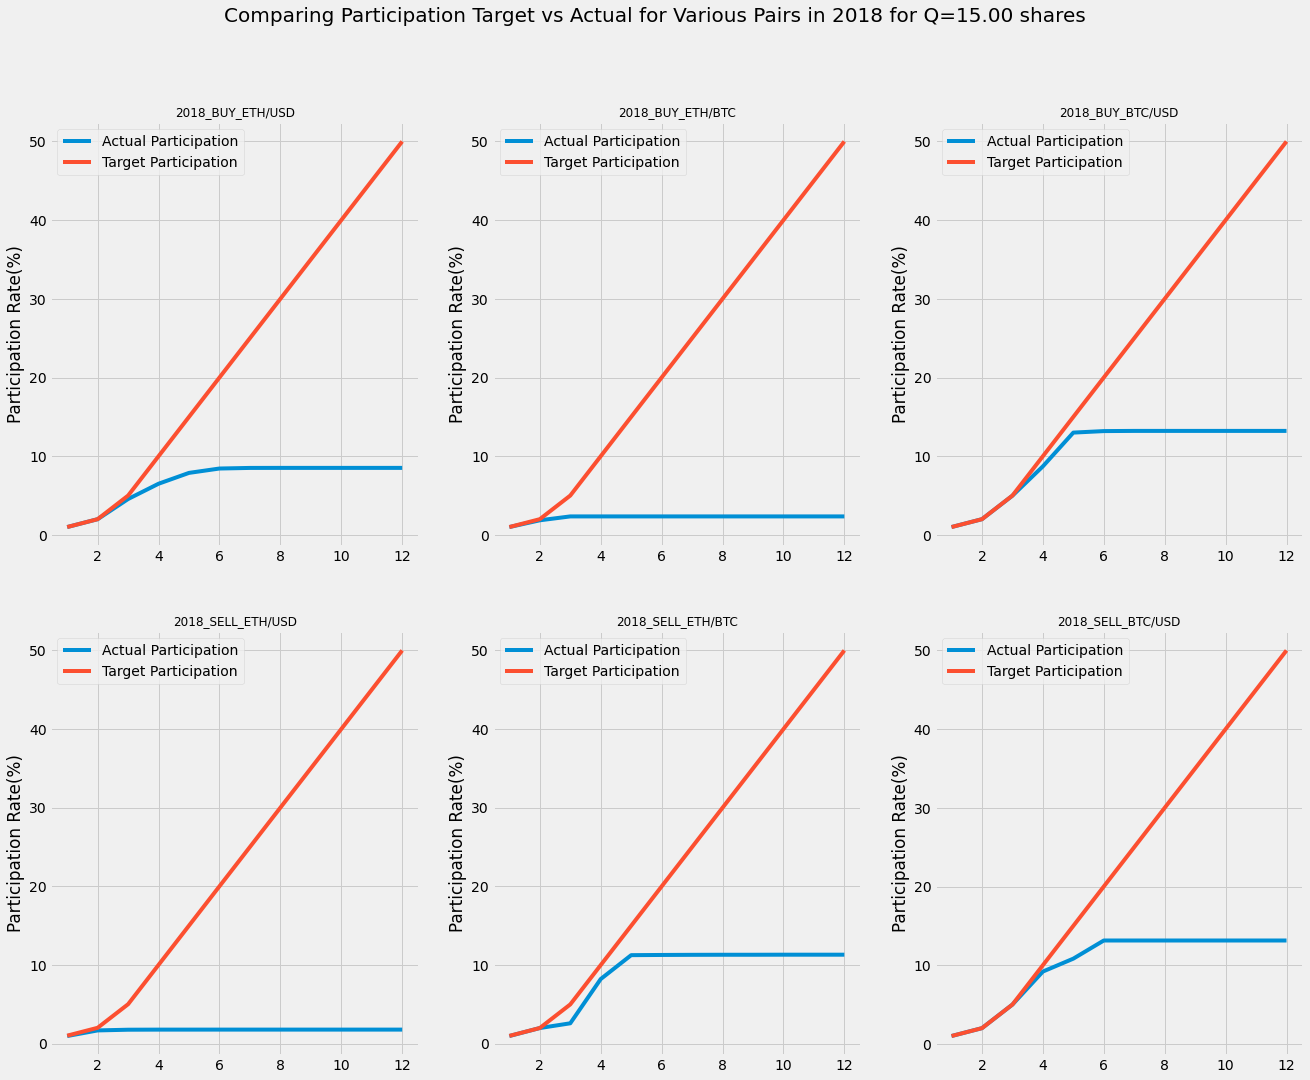

In [65]:
fig, axs = plt.subplots(2,3,figsize=(20,16))
plt.style.use('fivethirtyeight')
fig.suptitle('Comparing Participation Target vs Actual for Various Pairs in 2018 for Q=15.00 shares', fontsize = 20)

for i in range(int(len(tables_arr)/2)):
    y = []
    for j in range(len(tables_arr)):
        y.append(tables_arr[j].iloc[i]['Participation Rate(%)'])
        
    x = np.arange(1,len(tables_arr)+1)
    
    if i < 3:
        axs[0,i].plot(x, y, label='Actual Participation')
        axs[0,i].plot(x, p_arr*100, label='Target Participation')
        axs[0,i].set_title("{}".format(col_names[i]), fontsize = 12)
        axs[0,i].set_ylabel('Participation Rate(%)')
        axs[0,i].legend()
    else:
        axs[1,i-3].plot(x, y, label='Actual Participation')
        axs[1,i-3].plot(x, p_arr*100, label='Target Participation')
        axs[1,i-3].set_title("{}".format(col_names[i]), fontsize = 12)
        axs[1,i-3].set_ylabel('Participation Rate(%)')
        axs[1,i-3].legend()

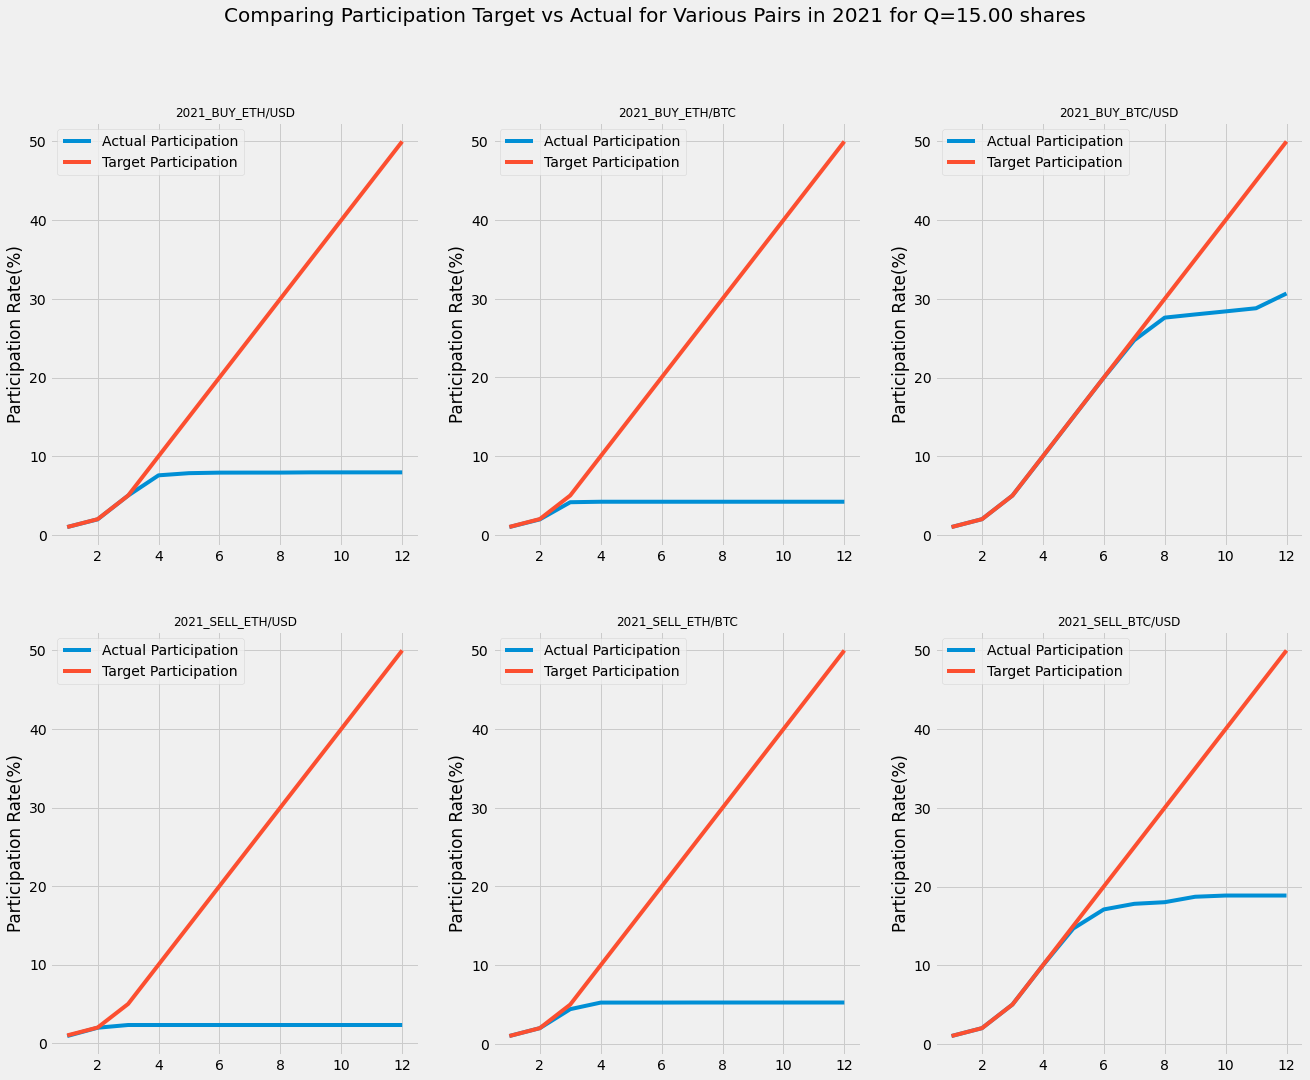

In [66]:
fig, axs = plt.subplots(2,3,figsize=(20,16))
plt.style.use('fivethirtyeight')
fig.suptitle('Comparing Participation Target vs Actual for Various Pairs in 2021 for Q=15.00 shares', fontsize = 20)

for i in range(int(len(tables_arr)/2)):
    y = []
    for j in range(len(tables_arr)):
        y.append(tables_arr[j].iloc[i+6]['Participation Rate(%)'])
        
    x = np.arange(1,len(tables_arr)+1)
    
    if i < 3:
        axs[0,i].plot(x, y, label='Actual Participation')
        axs[0,i].plot(x, p_arr*100, label='Target Participation')
        axs[0,i].set_title("{}".format(col_names[i+6]), fontsize = 12)
        axs[0,i].set_ylabel('Participation Rate(%)')
        axs[0,i].legend()
    else:
        axs[1,i-3].plot(x, y, label='Actual Participation')
        axs[1,i-3].plot(x, p_arr*100, label='Target Participation')
        axs[1,i-3].set_title("{}".format(col_names[i+6]), fontsize = 12)
        axs[1,i-3].set_ylabel('Participation Rate(%)')
        axs[1,i-3].legend()

The bigger the participation target the harder it is to try and keep up with the market. This definitely makes size based on the low amount of shares we are currently trading. 2021 BTC/USD keeps up with the participation target for higher value than the other candidate. This agrees with the participation rate analysis of BTC/USD section in chapter 3 where it seems to converge to a fast rate for $p=10\%$. Let's do same analysis but now with a larger $Q$.

In [67]:
tables_arr_2 = [generate_table(1000e9, 200, p, df_master_) for p in p_arr]

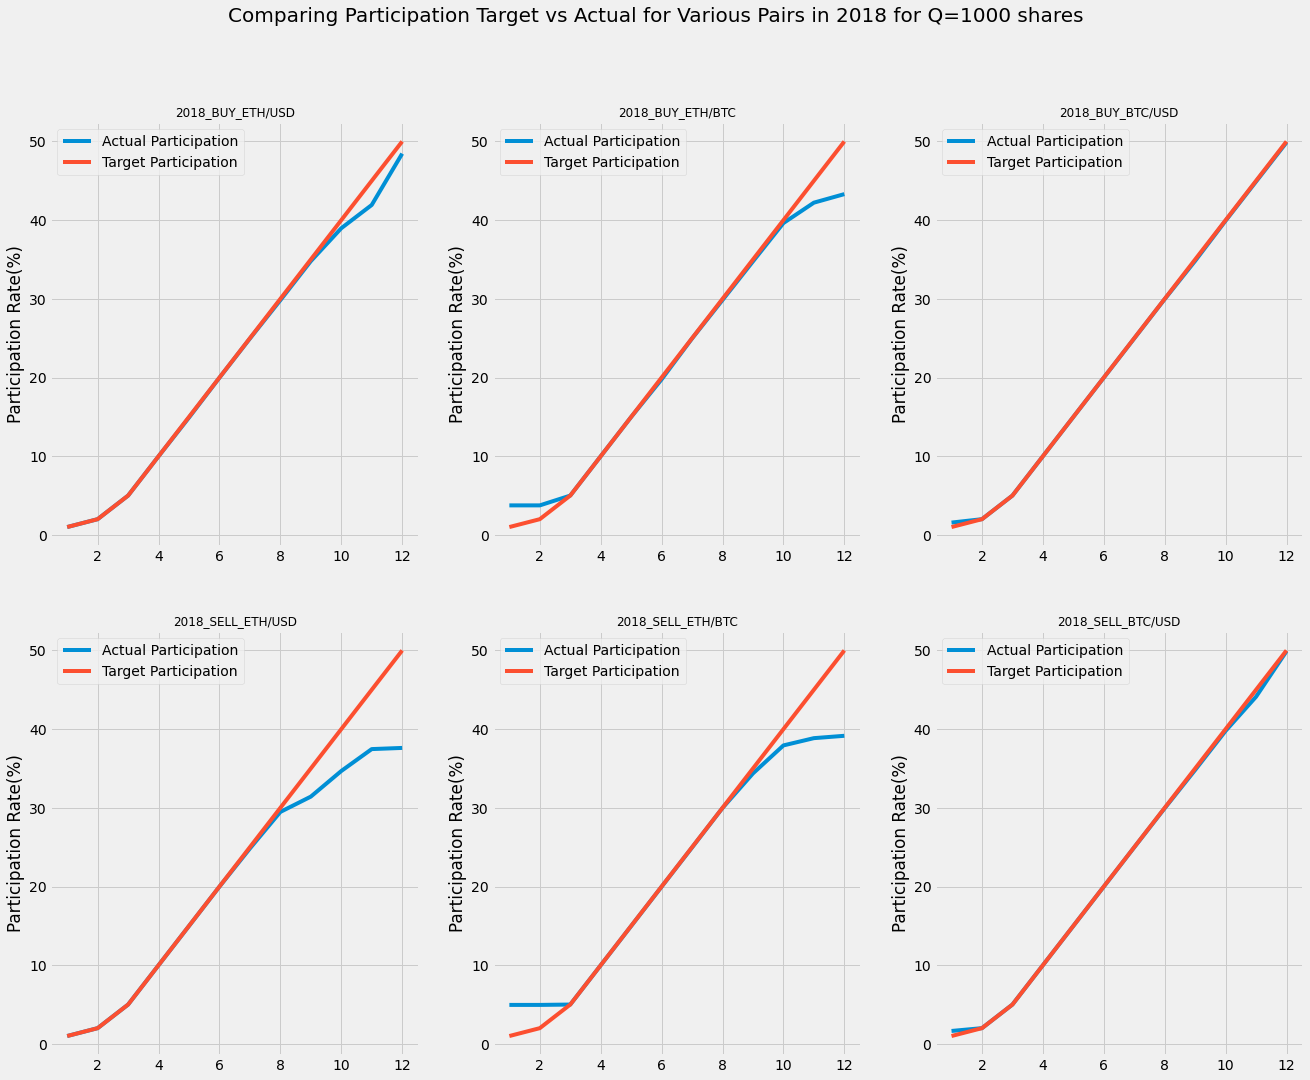

In [68]:
fig, axs = plt.subplots(2,3,figsize=(20,16))
plt.style.use('fivethirtyeight')
fig.suptitle('Comparing Participation Target vs Actual for Various Pairs in 2018 for Q=1000 shares', fontsize = 20)

for i in range(int(len(tables_arr_2)/2)):
    y = []
    for j in range(len(tables_arr_2)):
        y.append(tables_arr_2[j].iloc[i]['Participation Rate(%)'])
        
    x = np.arange(1,len(tables_arr_2)+1)
    
    if i < 3:
        axs[0,i].plot(x, y, label='Actual Participation')
        axs[0,i].plot(x, p_arr*100, label='Target Participation')
        axs[0,i].set_title("{}".format(col_names[i]), fontsize = 12)
        axs[0,i].set_ylabel('Participation Rate(%)')
        axs[0,i].legend()
    else:
        axs[1,i-3].plot(x, y, label='Actual Participation')
        axs[1,i-3].plot(x, p_arr*100, label='Target Participation')
        axs[1,i-3].set_title("{}".format(col_names[i]), fontsize = 12)
        axs[1,i-3].set_ylabel('Participation Rate(%)')
        axs[1,i-3].legend()

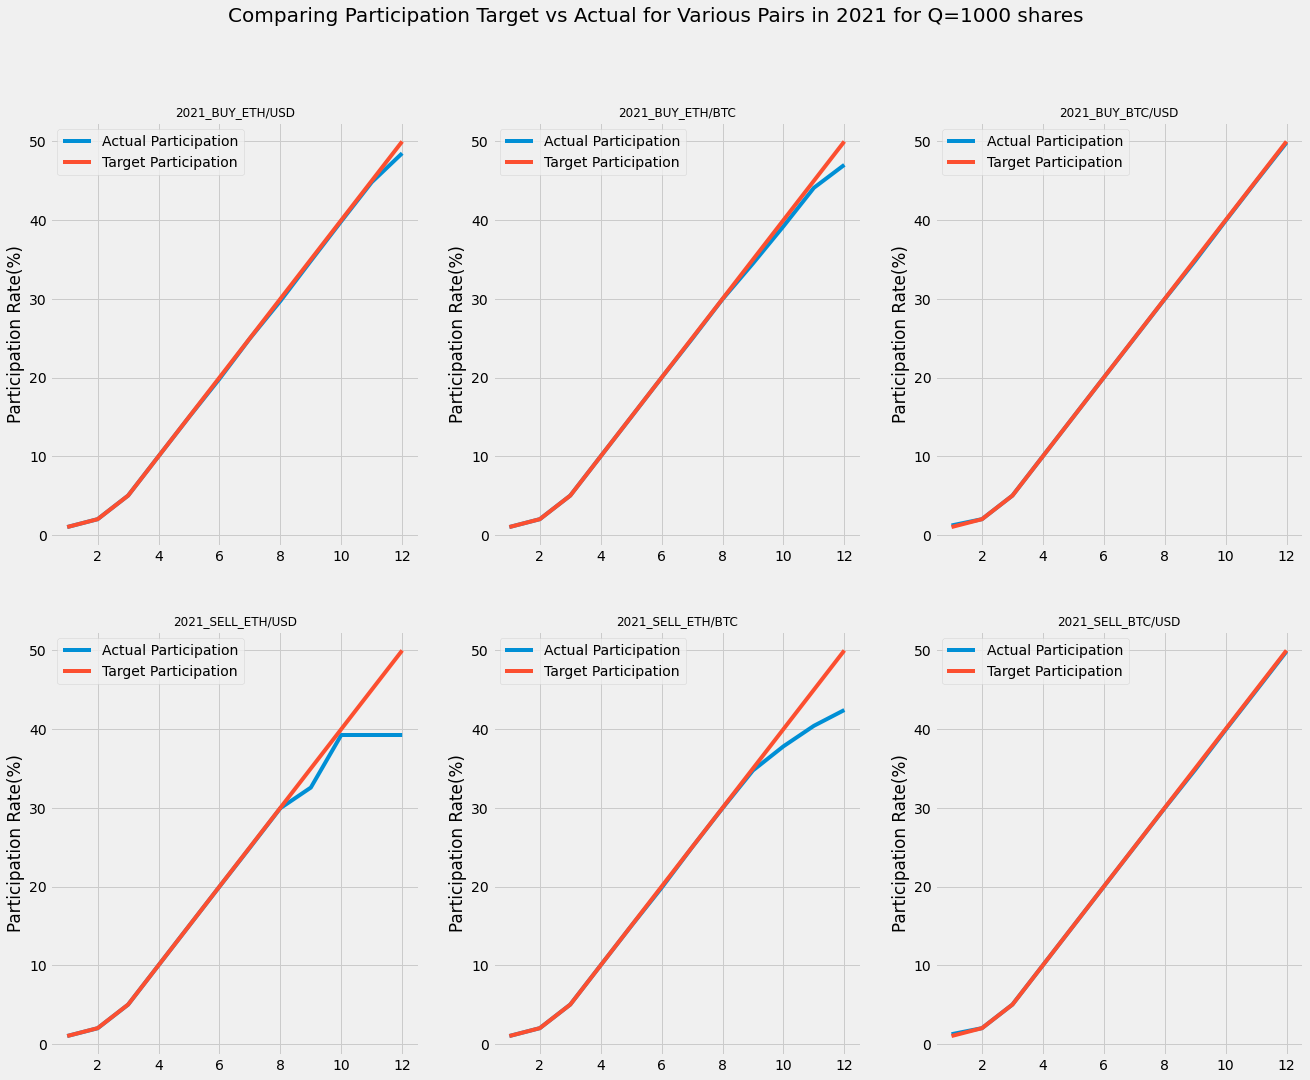

In [69]:
fig, axs = plt.subplots(2,3,figsize=(20,16))
plt.style.use('fivethirtyeight')
fig.suptitle('Comparing Participation Target vs Actual for Various Pairs in 2021 for Q=1000 shares', fontsize = 20)

for i in range(int(len(tables_arr_2)/2)):
    y = []
    for j in range(len(tables_arr_2)):
        y.append(tables_arr_2[j].iloc[i+6]['Participation Rate(%)'])
        
    x = np.arange(1,len(tables_arr_2)+1)
    
    if i < 3:
        axs[0,i].plot(x, y, label='Actual Participation')
        axs[0,i].plot(x, p_arr*100, label='Target Participation')
        axs[0,i].set_title("{}".format(col_names[i+6]), fontsize = 12)
        axs[0,i].set_ylabel('Participation Rate(%)')
        axs[0,i].legend()
    else:
        axs[1,i-3].plot(x, y, label='Actual Participation')
        axs[1,i-3].plot(x, p_arr*100, label='Target Participation')
        axs[1,i-3].set_title("{}".format(col_names[i+6]), fontsize = 12)
        axs[1,i-3].set_ylabel('Participation Rate(%)')
        axs[1,i-3].legend()

As we'd suspect, if the total quantity to be liquided is much higher and keeping the number of participation in the market the same, the notional of when we enter and trade in the market is much higher and we'd expect to be near participation target. Let's now check the ratio of sub-optimal for various participation target and for a small and big Q. Let's start for $Q=15$ shares.

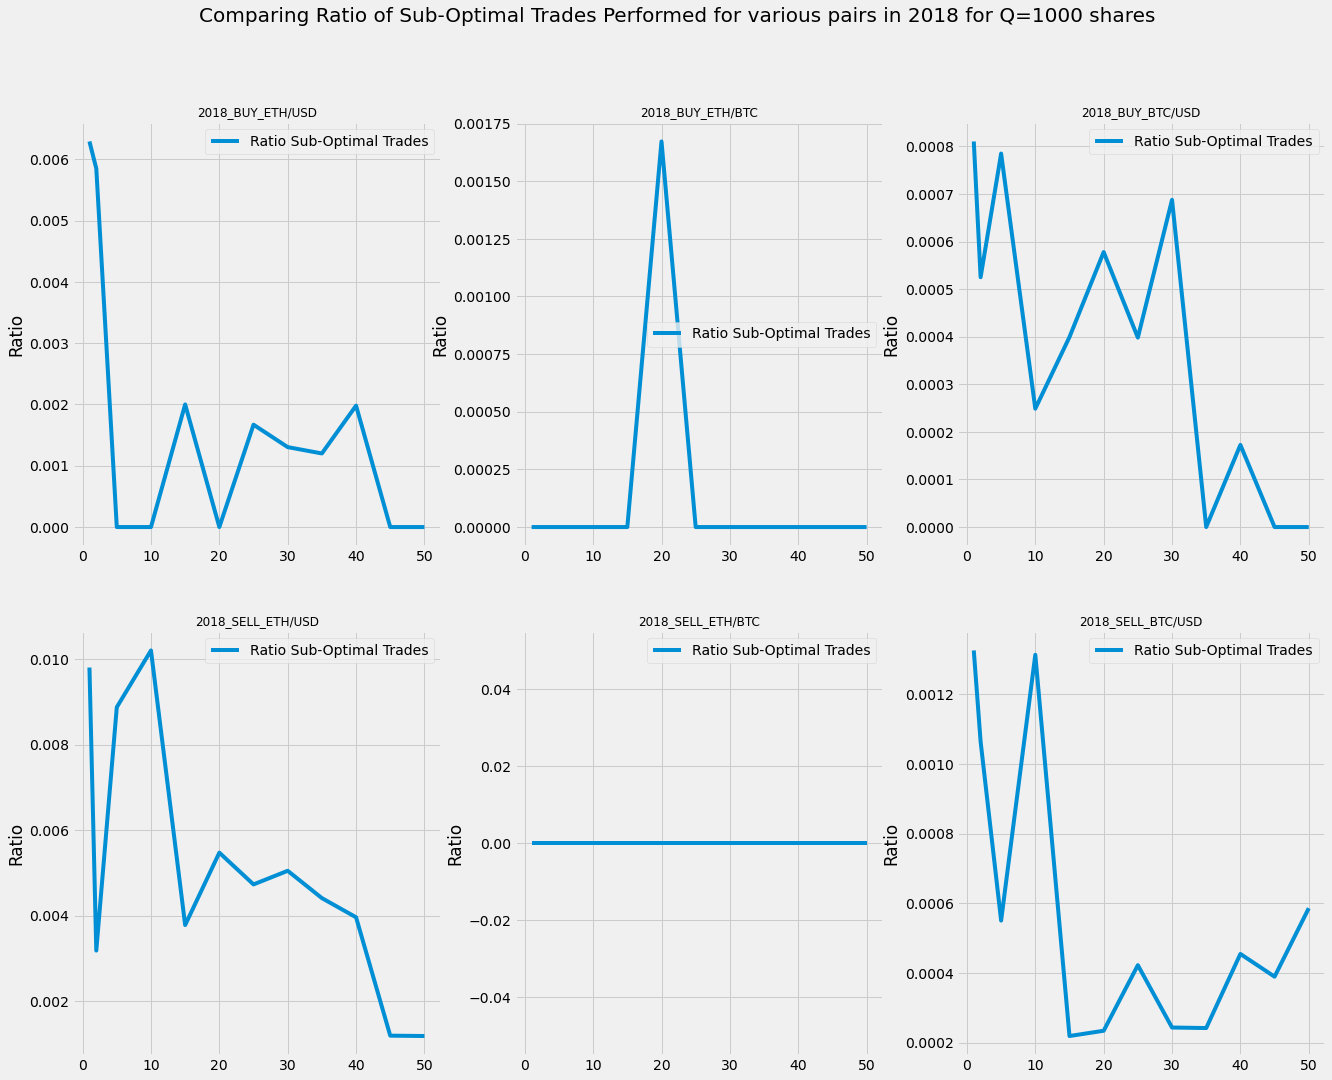

In [72]:
fig, axs = plt.subplots(2,3,figsize=(20,16))

fig.suptitle('Comparing Ratio of Sub-Optimal Trades Performed for various pairs in 2018 for Q=5 shares', fontsize = 20)

for i in range(int(len(tables_arr_2)/2)):
    y = []
    for j in range(len(tables_arr_2)):
        y.append(tables_arr_2[j].iloc[i]['Ratio Sub-Optimal Trades'])
           
    if i < 3:
        axs[0,i].plot(p_arr*100, y, label='Ratio Sub-Optimal Trades')
        axs[0,i].set_title("{}".format(col_names[i]), fontsize = 12)
        axs[0,i].set_ylabel('Ratio')
        axs[0,i].legend()
    else:
        axs[1,i-3].plot(p_arr*100, y, label='Ratio Sub-Optimal Trades')
        axs[1,i-3].set_title("{}".format(col_names[i]), fontsize = 12)
        axs[1,i-3].set_ylabel('Ratio')
        axs[1,i-3].legend()
             

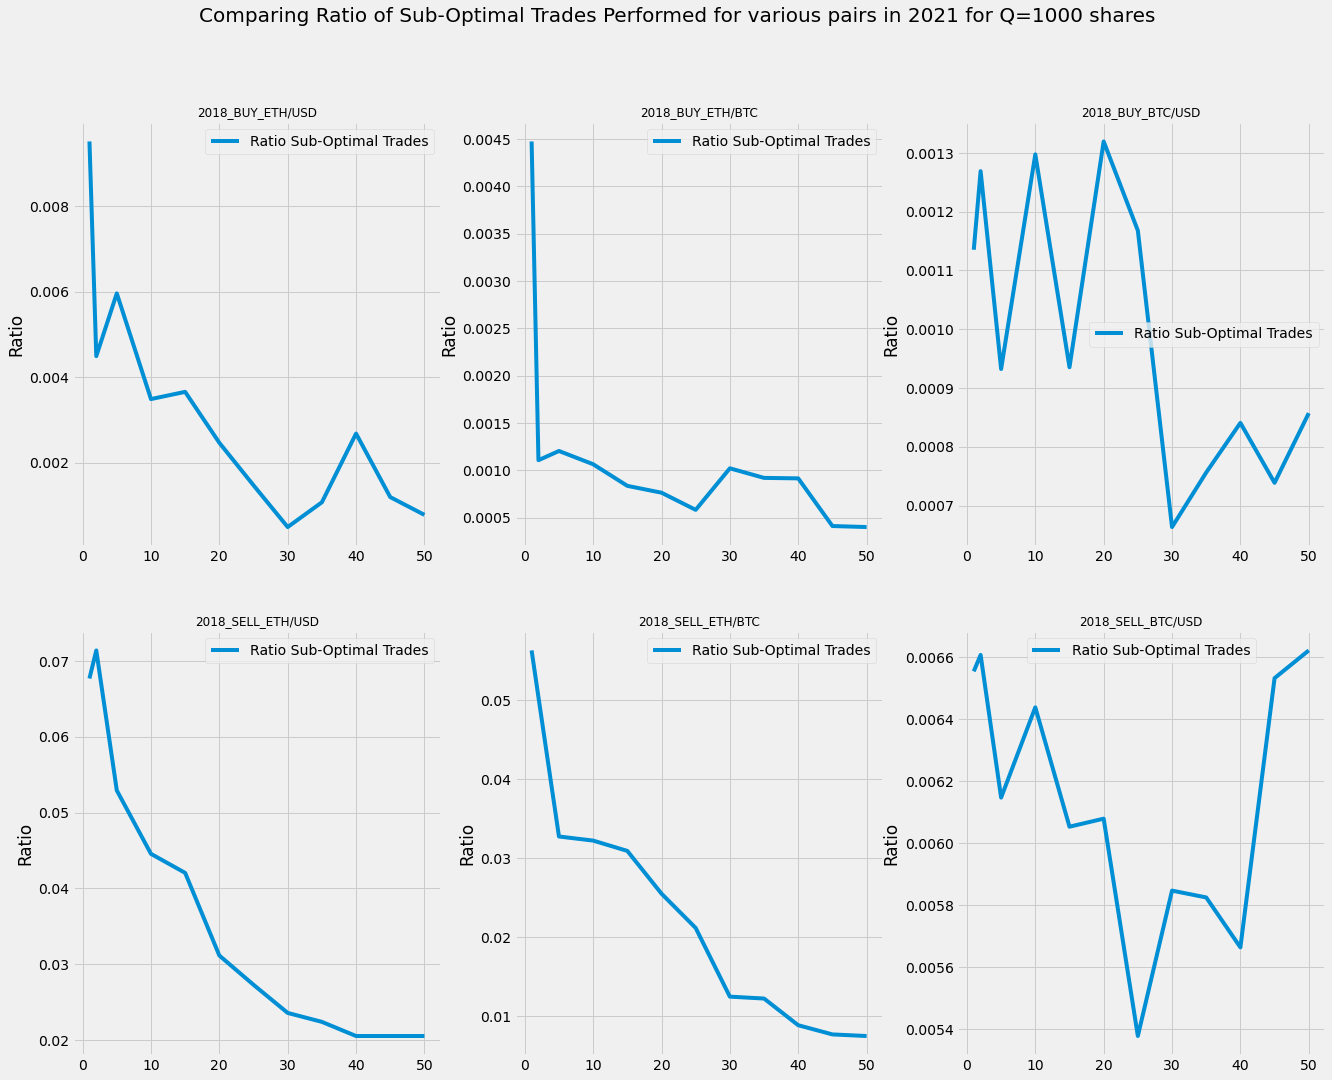

In [73]:
fig, axs = plt.subplots(2,3,figsize=(20,16))
plt.style.use('fivethirtyeight')
fig.suptitle('Comparing Ratio of Sub-Optimal Trades Performed for various pairs in 2021 for Q=1000 shares', fontsize = 20)

for i in range(int(len(tables_arr_2)/2)):
    y = []
    for j in range(len(tables_arr_2)):
        y.append(tables_arr_2[j].iloc[i+6]['Ratio Sub-Optimal Trades'])
           
    if i < 3:
        axs[0,i].plot(p_arr*100, y, label='Ratio Sub-Optimal Trades')
        axs[0,i].set_title("{}".format(col_names[i]), fontsize = 12)
        axs[0,i].set_ylabel('Ratio')
        axs[0,i].legend()
    else:
        axs[1,i-3].plot(p_arr*100, y, label='Ratio Sub-Optimal Trades')
        axs[1,i-3].set_title("{}".format(col_names[i]), fontsize = 12)
        axs[1,i-3].set_ylabel('Ratio')
        axs[1,i-3].legend()

There generally seems to be a trend that the Ratio of sub-optimal trades falls goes up as the participation rate goes up. This could be coming from the fact that with a higher pourcentage of participation of total volume, we'd expect to participate in most of the shares being traded in the next 0.1s so the trades that would be labeled as bad trades in one scenario isn't anymore because they were filled it anyways. It is difficult to make any meaningful interpretation considering how high the variance looks in all of those graphs and how few data points we have. We see erratic behavior in most of them and the ratio varies a lot.

# 5. Additional Notes

I chose not to do analysis on varying the level of number of participations in the market because I felt like it's effect were more obvious and I didn't want to add to the redundancy. While the effect of participating in the total volume of the market thus far is not so obvious, the size of the participation is. Say we have a small percentage of participation of total volume. If we have a large quantity to trade and a fix amount of participation, when we get involved in the market we might be trading for large notional at a time until exit so it's not clear how bad it will affect the optimal liquidation. While increasing the value of $c$ where we participate more often in the market which will reduce the size of the trades so our orders will be fulfilled quicker at the price available in the market without pushing the hypothetical book order more, so we would be expecting a better price. This actually turned out to be barely true if we go back to the comparison in the trade strategy of section 3. The reason was that we are not actually with the book order here but history of trades. The impact of bigger participation in chunk of trades would be greater in a more realistic trading scenario. Where it would become more interesting is if we added a fixed cost to trades and now see a penalty for interacting with the market more often. 

Which leads me to not analyzing much around transaction costs. The main reason was that given that our transaction cost is a % of nominal, analyzing the difference in nominal from optimal strategy versus execution strategy and first order based strategy of section two would come out to be the same. If transaction costs are simply a % of notional, then all I need to check is how my notional is changing in different environment versus target and the same information is there. If I had done some analysis of varying $c$ with fixed cost and how it changes nominal, then there would have been more interesting material to discuss.
